# Motive EDA notebooks

This notebook purpose is to create clean the data, create EDA for Motive's related dataset like, driver driving pattern, driver idling information, driver patterns related to hazard events, and car inspection. Once EDA is done. We calculate the relavant features selection by joinning all Motive related data

### Environment Setup

In [0]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import col, count, mean, stddev, min, max, when, isnan, countDistinct, lit, to_timestamp, to_date, hour, avg, sum, date_sub, current_date, datediff, floor, row_number, date_format, weekofyear, year, round, substring, concat, regexp_replace, max as Fmax, lag, last, rank, unix_timestamp, to_timestamp, expr

import seaborn as sns
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.window import Window
import matplotlib.pyplot  as plt 
import pandas as pd

In [0]:

app_name = "final-proj"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()

sc = spark.sparkContext

## Data Cleaning 

1. `data_combined_events_w_vehicle_map`
Here are some of the data cleaning steps that I am going to do for this table 
- drop NULL values from column driver_id 
- Checking if event_id is unique and not null (primary key); if event_id is primary key, drop the id column because the primary key for this table is event_id 
- Create new column called `main_event_type` with value "hazard" 
- Create `trip_date` column that is converted from `start_date` timestamp to date 

2. `data_driving_periods_w_vehicle_map`
Here are some of the data cleaning steps that I am going to do for this table 
- drop NULL values from column `driver_id` 
- Filter `minutes_driving` to be not null and have values larger than 0 
- Filter `driving_distance` to be not null and have values larger than 0 and less than 10000 (larger than 10000 are outliers from data exploratory)
- Count how many trip have `driving_distance` larger than 500 
- Check how many vehicle_id is null
- Checking if `event_id` is unique and not null (primary key); if `event_id` is primary key, drop the id column because the primary key for this table is `event_id`
- Create new column called `main_event_type` with value "driving" 
- Create a `trip_date` column from `start_date` timestamp
- Re-create `driver_company_id` in which it will make sure that the columns has the following format '001234' 

3. `data_inspections_w_vehicle_map`
Here are some of the data cleaning steps that I am going to do for this table 
- drop NULL values from column `driver_id` 
- Rename columns "status" to "inspection_status" and "status-2" to "status"
- Checking if `inspection_id` is unique and not null (primary key); if `inspection_id` is primary key, drop the `id` column because the primary key for this table is `inspection_id` 


4. `data_idle_events_w_vehicle_map`
Here are some of the data cleaning steps that I am going to do for this table 
- drop NULL values from column `driver_id` 
- Remove idling events that is larger than 500 minutes from column `minutes_idling` 
- Checking if `event_id` is unique and not null (primary key); if `event_id` is primary key, drop the `id_x` and `id_y column because the primary key for this table is `event_id` 
- Create `trip_date` from `start_date` timestamp 




In [0]:
## cleaning data_combined_events_w_vehicle_map
# Load the data
combined_event_data = spark.read.csv('dbfs:/FileStore/tables/data_combined_events_w_vehicle_map.csv', inferSchema=True, header=True)

# drop Null values
cleaned_combined_event_data = combined_event_data.dropna(subset=['driver_id'])
# chek if event_id is unique and not null
event_id_unique_count = cleaned_combined_event_data.select(countDistinct("event_id")).collect()[0][0]
total_count = cleaned_combined_event_data.count()
# check event_id not null 
null_event_id_count = cleaned_combined_event_data.filter(col("event_id").isNull()).count()

if null_event_id_count == 0 and event_id_unique_count == total_count:
    print("event_id is a primary key")
    # event_id is a primary key, so drop the id column
    cleaned_combined_event_data = cleaned_combined_event_data.drop("id")

# add main_event_type columns 
cleaned_combined_event_data = cleaned_combined_event_data.withColumn("main_event_type", lit("hazard"))

# add trip_date column
cleaned_combined_event_data = cleaned_combined_event_data.withColumn("trip_date", to_date("start_date"))
# cache the data
cleaned_combined_event_data = cleaned_combined_event_data.cache()

print(cleaned_combined_event_data.printSchema())
print("number of rows: ", cleaned_combined_event_data.count())
cleaned_combined_event_data.show()


event_id is a primary key
root
 |-- event_id: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- driver_id: double (nullable = true)
 |-- driver_first_name: string (nullable = true)
 |-- driver_last_name: string (nullable = true)
 |-- vehicle_id: integer (nullable = true)
 |-- coaching_status: string (nullable = true)
 |-- start_date: timestamp (nullable = true)
 |-- severity: string (nullable = true)
 |-- month: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- updated_at: timestamp (nullable = true)
 |-- max_over_speed_in_kph: double (nullable = true)
 |-- max_over_speed_in_mph: double (nullable = true)
 |-- not_current: boolean (nullable = true)
 |-- number: string (nullable = true)
 |-- status: string (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- group_id: double (nullable = true)
 |-- group_name: string (nullable = true)
 |-- main_event_type: string (nullable = false)
 |-- trip_date: date (n

In [0]:
from pyspark.sql.functions import col, count, when
# cleaning Driving period
# Load the data
driving_period = spark.read.csv('dbfs:/FileStore/tables/data_driving_periods_w_vehicle_map.csv', inferSchema=True, header=True)

# Drop NULL values from driver_id
cleaned_driving_period = driving_period.dropna(subset=['driver_id'])

# Filter minutes_driving to be non-null and greater than 0
cleaned_driving_period = cleaned_driving_period.filter((col("minutes_driving").isNotNull()) & (col("minutes_driving") > 0))

# Filter driving_distance to be non-null and greater than 0
cleaned_driving_period = cleaned_driving_period.filter((col("driving_distance").isNotNull()) & (col("driving_distance") > 0) & (col("driving_distance")<10000))

# Count how many trips have driving_distance > 500
high_distance_trips = cleaned_driving_period.filter(col("driving_distance") > 500).count()
print(f"Number of trips with driving_distance > 500: {high_distance_trips}")

# Check how many vehicle_id values are NULL
null_vehicle_id_count = cleaned_driving_period.filter(col("vehicle_id").isNull()).count()
print(f"Number of NULL vehicle_id values: {null_vehicle_id_count}")

# add main_event_type column
cleaned_driving_period = cleaned_driving_period.withColumn("main_event_type", lit("driving"))
# add trip_date column
cleaned_driving_period = cleaned_driving_period.withColumn("trip_date", to_date("start_date"))

# Convert 'end_date' from string to timestamp
cleaned_driving_period = cleaned_driving_period.withColumn("end_date", to_timestamp("end_date"))


null_event_id_count = cleaned_driving_period.filter(col("event_id").isNull()).count()
event_id_unique_count = cleaned_driving_period.select(countDistinct("event_id")).collect()[0][0]
total_count = cleaned_driving_period.count()

if null_event_id_count == 0 and event_id_unique_count == total_count:
    print("event_id is a primary key (unique and non-null)")
    # Drop id column since event_id is the primary key
    cleaned_driving_period = cleaned_driving_period.drop("id_y", "id_x")

# Create a new columns called `reformat_driver_company_id` 
cleaned_driving_period = cleaned_driving_period.withColumn(
    "driver_company_id_str",
    regexp_replace(col("driver_company_id").cast("string"), "\\.0$", "")  # Remove '.0' if present
)

cleaned_driving_period = cleaned_driving_period.withColumn(
    "reformat_driver_company_id",
    when(col("driver_company_id_str").isNull(), None)
    .when(substring(col("driver_company_id_str"), 1, 2) == "00", col("driver_company_id_str"))
    .otherwise(concat(lit("00"), col("driver_company_id_str")))
)

# remove data that have group_id is null and cache data 
cleaned_driving_period = cleaned_driving_period.filter(col("group_id").isNotNull()).cache()  
 
print(cleaned_driving_period.printSchema())
print("number of rows: ", cleaned_driving_period.count())
cleaned_driving_period.show()

Number of trips with driving_distance > 500: 19
Number of NULL vehicle_id values: 0
event_id is a primary key (unique and non-null)
root
 |-- event_id: long (nullable = true)
 |-- driver_id: double (nullable = true)
 |-- vehicle_id: integer (nullable = true)
 |-- start_date: timestamp (nullable = true)
 |-- end_date: timestamp (nullable = true)
 |-- driving_distance: double (nullable = true)
 |-- driving_period_type: string (nullable = true)
 |-- driver_company_id: string (nullable = true)
 |-- minutes_driving: double (nullable = true)
 |-- month: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- updated_at: timestamp (nullable = true)
 |-- unassigned: boolean (nullable = true)
 |-- not_current: string (nullable = true)
 |-- number: string (nullable = true)
 |-- status: string (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- group_id: double (nullable = true)
 |-- group_name: string (nullable = true)
 |-- main_even

In [0]:
driving_period =cleaned_driving_period.toPandas()
driving_period[driving_period["driver_id"] == 4967877.0].sort_values(by = "trip_date", ascending = False)

,event_id,driver_id,vehicle_id,start_date,end_date,driving_distance,driving_period_type,driver_company_id,minutes_driving,month,created_at,updated_at,unassigned,not_current,number,status,make,model,group_id,group_name,main_event_type,trip_date,driver_company_id_str,reformat_driver_company_id
2048619,2949303335,4967877.0,1705399,2025-01-15 14:37:05,2025-01-15 15:48:54,48.1,driving,2189,71.816667,January,2025-01-16 09:00:13.717258,2025-02-15 07:56:30.503516,False,nan,LJ-5,active,HINO,Incomplete Vehicle,137745.0,SC - Littlejohn,driving,2025-01-15,2189,002189
2047648,2949800582,4967877.0,1705399,2025-01-15 16:48:45,2025-01-15 16:50:24,0.4,driving,2189,1.650000,January,2025-01-16 09:00:13.211026,2025-02-15 07:56:27.494198,False,nan,LJ-5,active,HINO,Incomplete Vehicle,137745.0,SC - Littlejohn,driving,2025-01-15,2189,002189
651245,2949845868,4967877.0,1705399,2025-01-15 17:01:05,2025-01-15 17:10:01,2.4,driving,2189,8.933333,January,2025-01-16 09:00:13.211026,2025-02-15 07:56:27.494198,False,nan,LJ-5,active,HINO,Incomplete Vehicle,137745.0,SC - Littlejohn,driving,2025-01-15,2189,002189
2048608,2949601574,4967877.0,1705399,2025-01-15 15:57:28,2025-01-15 15:58:08,0.1,driving,2189,0.666667,January,2025-01-16 09:00:13.211026,2025-02-15 07:56:28.824439,False,nan,LJ-5,active,HINO,Incomplete Vehicle,137745.0,SC - Littlejohn,driving,2025-01-15,2189,002189
719987,2950304487,4967877.0,1705399,2025-01-15 18:58:43,2025-01-15 18:59:38,0.2,driving,2189,0.916667,January,2025-01-16 09:00:12.109499,2025-02-15 07:56:26.035781,False,nan,LJ-5,active,HINO,Incomplete Vehicle,137745.0,SC - Littlejohn,driving,2025-01-15,2189,002189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157666,2578226651,4967877.0,1705399,2024-08-05 17:28:40,2024-08-05 18:00:51,6.8,driving,2189,32.183333,August,2024-08-12 20:40:37.017439,2024-11-22 21:21:13.492026,False,nan,LJ-5,active,HINO,Incomplete Vehicle,137745.0,SC - Littlejohn,driving,2024-08-05,2189,002189
1157030,2578338037,4967877.0,1705399,2024-08-05 18:04:59,2024-08-05 18:29:00,8.1,driving,2189,24.016667,August,2024-08-12 20:40:37.017439,2024-11-22 21:21:13.492026,False,nan,LJ-5,active,HINO,Incomplete Vehicle,137745.0,SC - Littlejohn,driving,2024-08-05,2189,002189
1156918,2578436895,4967877.0,1705399,2024-08-05 18:36:39,2024-08-05 18:37:13,0.1,driving,2189,0.566667,August,2024-08-12 20:40:37.017439,2024-11-22 21:21:13.492026,False,nan,LJ-5,active,HINO,Incomplete Vehicle,137745.0,SC - Littlejohn,driving,2024-08-05,2189,002189
1159946,2577666559,4967877.0,1705399,2024-08-05 14:30:36,2024-08-05 14:47:16,4.2,driving,2189,16.666667,August,2024-08-12 20:40:38.716910,2024-11-22 21:21:16.362349,False,nan,LJ-5,active,HINO,Incomplete Vehicle,137745.0,SC - Littlejohn,driving,2024-08-05,2189,002189


In [0]:
## Inspection Data
inspection_data = spark.read.csv('dbfs:/FileStore/tables/data_inspections_w_vehicle_map.csv', inferSchema=True, header=True)

cleaned_inspection_data = inspection_data.dropna(subset=['driver_id'])

# Rename columns: "status" → "inspection_status" and "status-2" → "status"
cleaned_inspection_data = cleaned_inspection_data.withColumnRenamed("status", "inspection_status").withColumnRenamed("status-2", "status")

# Check if inspection_id is unique and not null
null_inspection_id_count = cleaned_inspection_data.filter(col("inspection_id").isNull()).count()
inspection_id_unique_count = cleaned_inspection_data.select(countDistinct("inspection_id")).collect()[0][0]
total_count = cleaned_inspection_data.count()

if null_inspection_id_count == 0 and inspection_id_unique_count == total_count:
    print("inspection_id is a primary key (unique and non-null)")
    # Drop id column since inspection_id is the primary key
    cleaned_inspection_data = cleaned_inspection_data.drop("id")

# add main_event_type column
cleaned_inspection_data = cleaned_inspection_data.withColumn("main_event_type", lit("inspection"))
# cache data 
cleaned_inspection_data = cleaned_inspection_data.cache()

print(cleaned_inspection_data.printSchema())
print(cleaned_inspection_data.count())
cleaned_inspection_data.show()


inspection_id is a primary key (unique and non-null)
root
 |-- inspection_id: long (nullable = true)
 |-- vehicle_id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- location: string (nullable = true)
 |-- inspection_status: string (nullable = true)
 |-- inspection_type: string (nullable = true)
 |-- driver_id: integer (nullable = true)
 |-- mechanic_id: string (nullable = true)
 |-- reviewer_id: string (nullable = true)
 |-- number: string (nullable = true)
 |-- status: string (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- main_event_type: string (nullable = false)

None
215292
+-------------+----------+----------+--------------------+-----------------+---------------+---------+-----------+-----------+-------------+-----------+--------------+--------------------+---------------+
|inspection_id|vehicle_id|      date|            location|inspection_status|inspection_type|driver_id|mechanic_id|reviewer_id|       number|   

In [0]:
## Idle Events
idle_data = spark.read.csv('dbfs:/FileStore/tables/data_idle_events_w_vehicle_map.csv', inferSchema=True, header=True)

cleaned_idle_data = idle_data.dropna(subset=['driver_id'])

# Remove idling events where minutes_idling > 500
cleaned_idle_data = cleaned_idle_data.filter(col("minutes_idling") <= 500)

# Check if event_id is unique and not null
null_event_id_count = cleaned_idle_data.filter(col("event_id").isNull()).count()
event_id_unique_count = cleaned_idle_data.select(countDistinct("event_id")).collect()[0][0]
total_count = cleaned_idle_data.count()

if null_event_id_count == 0 and event_id_unique_count == total_count:
    print("event_id is a primary key (unique and non-null)")
    # Drop id_x and id_y columns since event_id is the primary key
    cleaned_idle_data = cleaned_idle_data.drop("id_x", "id_y")

# add trip_date from start_date timestamp
cleaned_idle_data = cleaned_idle_data.withColumn("idle_date", to_date("start_time"))

# add main_event_type column
cleaned_idle_data = cleaned_idle_data.withColumn("main_event_type", lit("idle"))
# cache data 
cleaned_idle_data = cleaned_idle_data.cache()

print(cleaned_idle_data.printSchema())
print(cleaned_idle_data.count())
cleaned_idle_data.show()

event_id is a primary key (unique and non-null)
root
 |-- event_id: long (nullable = true)
 |-- start_time: timestamp (nullable = true)
 |-- end_time: timestamp (nullable = true)
 |-- vehicle_id: integer (nullable = true)
 |-- driver_id: double (nullable = true)
 |-- driver_company_id: double (nullable = true)
 |-- minutes_idling: double (nullable = true)
 |-- number: string (nullable = true)
 |-- status: string (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- group_id: double (nullable = true)
 |-- group_name: string (nullable = true)
 |-- idle_date: date (nullable = true)
 |-- main_event_type: string (nullable = false)

None
4264634
+----------+-------------------+-------------------+----------+---------+-----------------+------------------+------------+-----------+-------------+--------------------+--------+--------------------+----------+---------------+
|  event_id|         start_time|           end_time|vehicle_id|driver_id|driver_co

## Raw Features 
Before going through the EDA and do some transformation for features engineering. Here are the list of raw columns for each tables: 

#### `data_inspections_w_vehicle_map`

The `data_inspections_w_vehicle_map` table records truck inspections at the beginning of the day/ before trips and post-trip to ensure compliance with safety checks. These records range from Jan 2023- March 2025  
- Each row represents an individual inspection log.  
- **Primary Key:** `inspection_id` (unique identifier for each inspection record).  
- **Unique Constraint:** `(vehicle_id, date, inspection_type)`, ensuring a vehicle is inspected only once per type per day.  
- **Duplicate Handling:** Drivers may accidentally log multiple inspections on the same day, or omit `inspection_type`.  

| **Column Name**     | **Data Type** | **Description**                                                                       |
| ------------------- | ------------- | ------------------------------------------------------------------------------------- |
| **id**              | `INTEGER`     | Auto-incremented unique row identifier (optional primary key alternative).            |
| **inspection_id**   | `INTEGER`     | Unique identifier for the inspection log.                                             |
| **vehicle_id**      | `INTEGER`     | Unique ID assigned to the vehicle being inspected.                                    |
| **date**            | `DATE`        | The date when the inspection occurred (`YYYY-MM-DD`).                                 |
| **location**        | `VARCHAR`     | The physical location where the inspection took place.                                |
| **status**          | `VARCHAR`     | The inspection status (`acceptable`, `open`, `resolved`).                             |
| **inspection_type** | `VARCHAR`     | Type of inspection performed (`pre-trip`, `post-trip`). May be missing in some cases. |
| **driver_id**       | `INTEGER`     | The unique identifier of the driver performing the inspection.                        |
| **mechanic_id**     | `INTEGER`     | Mechanic’s ID, if the inspection required mechanic review.                            |
| **reviewer_id**     | `INTEGER`     | ID of the reviewer who validates or approves the inspection.                          |                                                  |


**Notes**
- **Each inspection is linked to a `vehicle_id` and `date`, ensuring tracking of daily vehicle inspections.**  
- **Duplicate inspections may occur** due to drivers mistakenly logging multiple entries. Data validation should account for this.  
- **Inspection type (`pre-trip`, `post-trip`) may be missing**, requiring data cleansing or defaulting.  
- **Vehicles remain active (`status-2`) unless deactivated**, indicating whether the truck is still in service.  
- **Foreign keys (`driver_id`, `mechanic_id`, `reviewer_id`)** should link to the respective user/employee database for consistency. 
- This process is not rigorously being  implemented; therefore, a lot of missing information 

#### `data_idle_events_w_vehicle_map`
The `data_idle_events_w_vehicle_map` table records idle events whenever a truck is idling during a trip, within the driver's clock-in and clock-out hours.  These records range from Jan 2023- March 2025  
- Each row represents a single idle event, capturing start time, end time, and duration.
- Idle events are logged per `event_id` whenever a truck is idling during a trip within clock-in/out hours.  
- **Primary Key:** `event_id` (unique identifier for each idle event).
 
| **Column Name**       | **Data Type** | **Description**                                                                |
| --------------------- | ------------- | ------------------------------------------------------------------------------ |
| **id**                | `INTEGER`     | Auto-incremented unique row identifier (optional).                             |
| **event_id**          | `INTEGER`     | Unique identifier for each idle event (Primary Key).                           |
| **start_time**        | `TIMESTAMP`   | The timestamp when idling began.                                               |
| **end_time**          | `TIMESTAMP`   | The timestamp when idling ended.                                               |
| **driver_company_id** | `INTEGER`     | The driver’s company ID (from Motive's system).                                |
| **driver_id**         | `INTEGER`     | Unique identifier for the driver.                                              |
| **minutes_idling**    | `INTEGER`     | Total duration (in minutes) the truck remained idle or the driver was resting. |


#### `data_driving_periods_w_vehicle_map`

The `data_driving_periods_w_vehicle_map` table tracks driving sessions for truck drivers, linking them to vehicles and recording trip details such as distance, timestamps, and driving type.  These records range from Jan 2023- March 2025  
- Each row represents **a single driving period** (a continuous driving session).  
- **Primary Key:** `event_id` (unique identifier for each driving period).  
- **Unassigned Trips:** If a driver does not log into the Motive mobile app, the trip is recorded under `"unassigned"`.  
- **Trip Classification:** The column `driving_period_type` categorizes trips as `driving`, `pc` (Personal Conveyance), or `ym` (Yard Move).  

| **Column Name**         | **Data Type**   | **Description**                                                                                            |
| ----------------------- | --------------- | ---------------------------------------------------------------------------------------------------------- |
| **id**                  | `INTEGER`       | Auto-incremented unique row identifier (optional).                                                         |
| **event_id**            | `INTEGER`       | Unique identifier for each driving period (Primary Key).                                                   |
| **driver_id**           | `INTEGER`       | Unique identifier for the driver. If unassigned, marked as `"unassigned"`.                                 |
| **driver_first_name**   | `VARCHAR`       | The first name of the driver (if signed in).                                                               |
| **driver_last_name**    | `VARCHAR`       | The last name of the driver (if signed in).                                                                |
| **vehicle_id**          | `INTEGER`       | Unique identifier of the vehicle used in the driving session.                                              |
| **start_date**          | `TIMESTAMP`     | Start time of the driving period.                                                                          |
| **end_date**            | `TIMESTAMP`     | End time of the driving period.                                                                            |
| **driving_distance**    | `DECIMAL(10,2)` | Distance driven in miles or kilometers (depending on system settings).                                     |
| **driving_period_type** | `VARCHAR`       | Categorization of trip type: `driving`, `pc` (Personal Conveyance), or `ym` (Yard Move).                   |
| **driver_company_id**   | `INTEGER`       | The driver’s company ID from Motive's system.                                                              |
| **minutes_driving**     | `INTEGER`       | Total time (in minutes) spent driving during the session.                                                  |
| **month**               | `INTEGER`       | The month (same as `start_date`) when the trip started.                                                    |
| **created_at**          | `TIMESTAMP`     | Timestamp when the driving period record was created.                                                      |
| **updated_at**          | `TIMESTAMP`     | Timestamp when the record was last updated.                                                                |
| **unassigned**          | `BOOLEAN`       | Indicates if the driver was logged in (`false`) or if the trip was recorded under `"unassigned"` (`true`). |
| **not_current**         | `BOOLEAN`       | Indicates whether the record is outdated (`true`) or active (`null`).                                      |
| **number**              | `VARCHAR`       | The vehicle's unique number in the company’s tracking system.                                              |
| **status-2**            | `VARCHAR`       | The vehicle’s operational status (`active`, `deactivated`).                                                |
| **make**                | `VARCHAR`       | The manufacturer or main company of the vehicle.                                                           |
| **model**               | `VARCHAR`       | The specific model of the vehicle.                                                                         |

#### `data_combined_events_w_vehicle_map`

The `data_combined_events_w_vehicle_map` table consolidates **safety and operational events** detected by the Motive system. This includes **hazard events, safety violations, coaching interventions, vehicle information, and status tracking**.  These records range from Jan 2023- March 2025  
- **Each row represents a recorded event** associated with a driver and vehicle.  
- **Primary Key:** `event_id` (unique identifier for each event).  
- **Contains both driving behavior events and vehicle-specific information**.  

| **Column Name**           | **Data Type**  | **Description**                                                                                                                                                                                                                                                                                                                                          |
| ------------------------- | -------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **id**                    | `INTEGER`      | Auto-incremented unique row identifier (optional).                                                                                                                                                                                                                                                                                                       |
| **event_id**              | `INTEGER`      | Unique identifier for each event (Primary Key).                                                                                                                                                                                                                                                                                                          |
| **type**                  | `VARCHAR`      | The type of event recorded. One of: `camera_obstruction`, `cell_phone`, `crash`, `distraction`, `driver_facing_cam_obstruction`, `drowsiness`, `forward_collision_warning`, `manual_event`, `near_miss`, `ran_a_red_light`, `road_facing_cam_obstruction`, `seat_belt_violation`, `speeding`, `stop_sign_violation`, `tailgating`, `unsafe_lane_change`. |
| **driver_id**             | `INTEGER`      | Unique identifier for the driver involved in the event.                                                                                                                                                                                                                                                                                                  |
| **driver_first_name**     | `VARCHAR`      | The first name of the driver.                                                                                                                                                                                                                                                                                                                            |
| **driver_last_name**      | `VARCHAR`      | The last name of the driver.                                                                                                                                                                                                                                                                                                                             |
| **vehicle_id**            | `INTEGER`      | Unique identifier of the vehicle associated with the event.                                                                                                                                                                                                                                                                                              |
| **coaching_status**       | `VARCHAR`      | The coaching review status for the event. Options: `Pending Review`, `Coachable`, `Coached`, `Uncoachable`.                                                                                                                                                                                                                                              |
| **start_date**            | `TIMESTAMP`    | The time when the driver start driving                                                                                                                                                                                                                                                                                                                   |
| **severity**              | `VARCHAR`      | The severity level of the event (`Low`, `Moderate`, `Severe`).                                                                                                                                                                                                                                                                                           |
| **group_id**              | `INTEGER`      | The group (e.g., department or fleet) associated with the driver.                                                                                                                                                                                                                                                                                        |
| **group_name**            | `VARCHAR`      | The name of the driver’s assigned group.                                                                                                                                                                                                                                                                                                                 |
| **month**                 | `INTEGER`      | The month (same as `start_date`) when the event occurred.                                                                                                                                                                                                                                                                                                |
| **created_at**            | `TIMESTAMP`    | Timestamp when the event record was created.                                                                                                                                                                                                                                                                                                             |
| **updated_at**            | `TIMESTAMP`    | Timestamp when the record was last updated (typically when `coaching_status` changes).                                                                                                                                                                                                                                                                   |
| **max_over_speed_in_kph** | `DECIMAL(5,2)` | Maximum recorded speed over the limit (in kilometers per hour) for speeding violations.                                                                                                                                                                                                                                                                  |
| **max_over_speed_in_mph** | `DECIMAL(5,2)` | Maximum recorded speed over the limit (in miles per hour) for speeding violations.                                                                                                                                                                                                                                                                                                |

## EDA for all tables 
This notebook is used to clean the data and aggregated them into 1 big table for our data analysis. We are going to clean the following tables:
#### `data_combined_events_w_vehicle_map.csv`
#### EDA Questions: 
- what is the total event count throughout each months? 
- what are the top 5 common events by count per month (from `type`)
- what are the top 5 locations with highest event count per year?
- when speeding, what speeding range is the most common? (histogram)

- the count distributions for each coaching type? 
-  Average Number of Coached Events per year



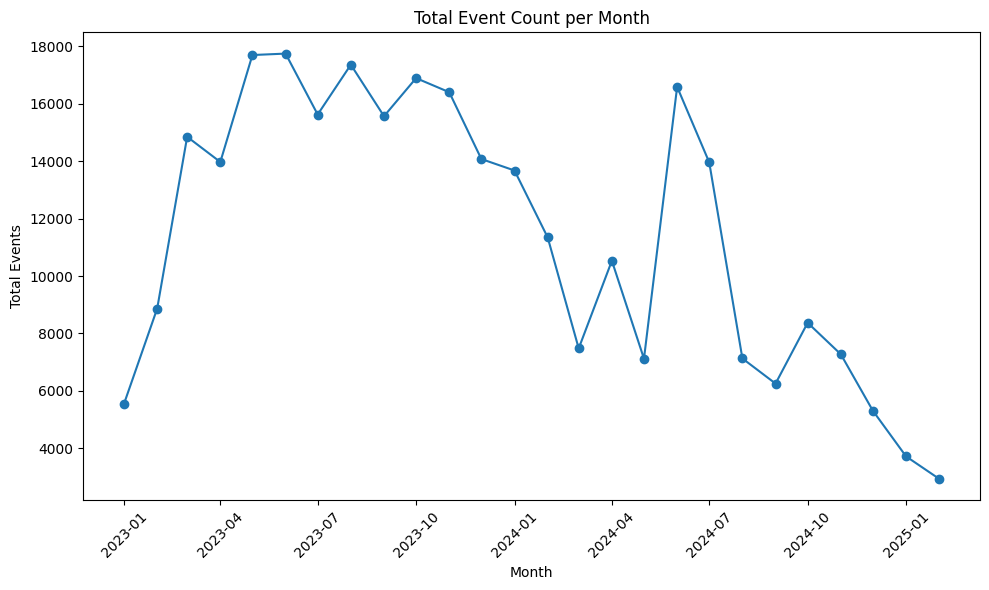

In [0]:
#1. Total event count per month
driver_month_event_count = cleaned_combined_event_data.withColumn(
    "month", date_format("trip_date", "yyyy-MM")).groupBy("month").agg(count("*").alias("total_events"))

driver_month_event_count_pd = driver_month_event_count.orderBy("month").toPandas()
# Convert the 'month' column to a datetime object for proper sorting and plotting
driver_month_event_count_pd['month'] = pd.to_datetime(driver_month_event_count_pd['month'], format='%Y-%m')
driver_month_event_count_pd.sort_values('month', inplace=True)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(driver_month_event_count_pd['month'], driver_month_event_count_pd['total_events'], marker='o')
plt.title("Total Event Count per Month")
plt.xlabel("Month")
plt.ylabel("Total Events")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

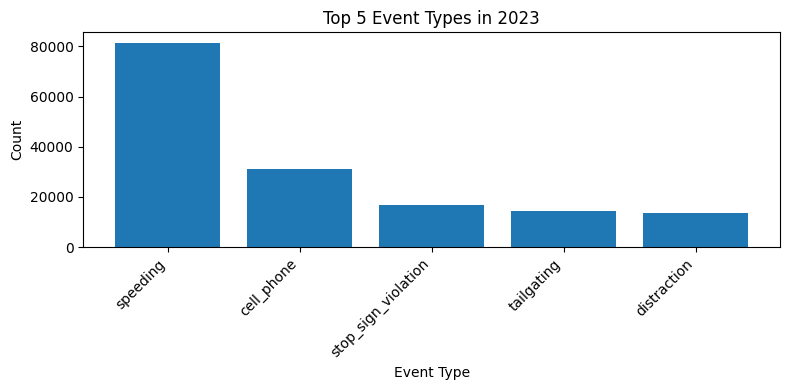

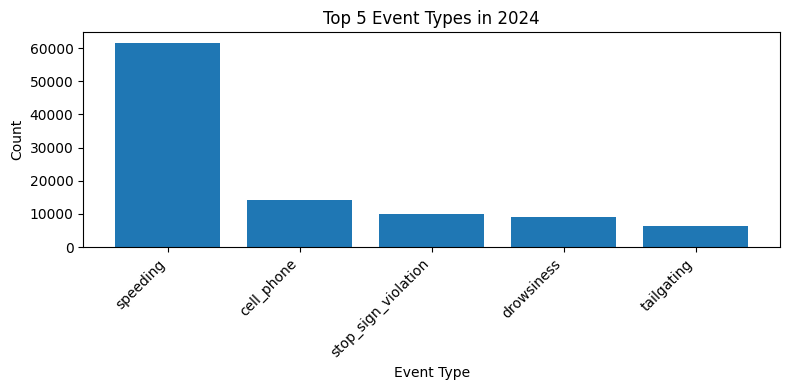

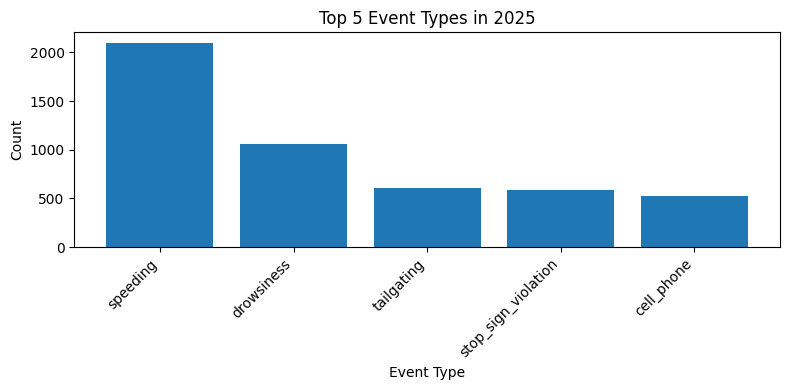

In [0]:
### top 5 most common events by count per year
event_type_counts_year = cleaned_combined_event_data.withColumn(
    "year", date_format("trip_date", "yyyy")
).groupBy("year", "type").agg(
    count("*").alias("event_count")
)

# Define a window partitioned by year and order by event_count in descending order
windowSpec_year = Window.partitionBy("year").orderBy(col("event_count").desc())

# Compute the rank per year and filter for the top 5 events
top5_event_types_per_year = event_type_counts_year.withColumn(
    "rank", rank().over(windowSpec_year)
).filter(col("rank") <= 5)

# Convert the result to a Pandas DataFrame for plotting
top5_event_types_pd_year = top5_event_types_per_year.toPandas()

# For each year, create a bar chart of the top 5 event types
years = top5_event_types_pd_year["year"].unique()
for y in years:
    data_year = top5_event_types_pd_year[top5_event_types_pd_year["year"] == y]
    plt.figure(figsize=(8,4))
    plt.bar(data_year["type"], data_year["event_count"])
    plt.title(f"Top 5 Event Types in {y}")
    plt.xlabel("Event Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

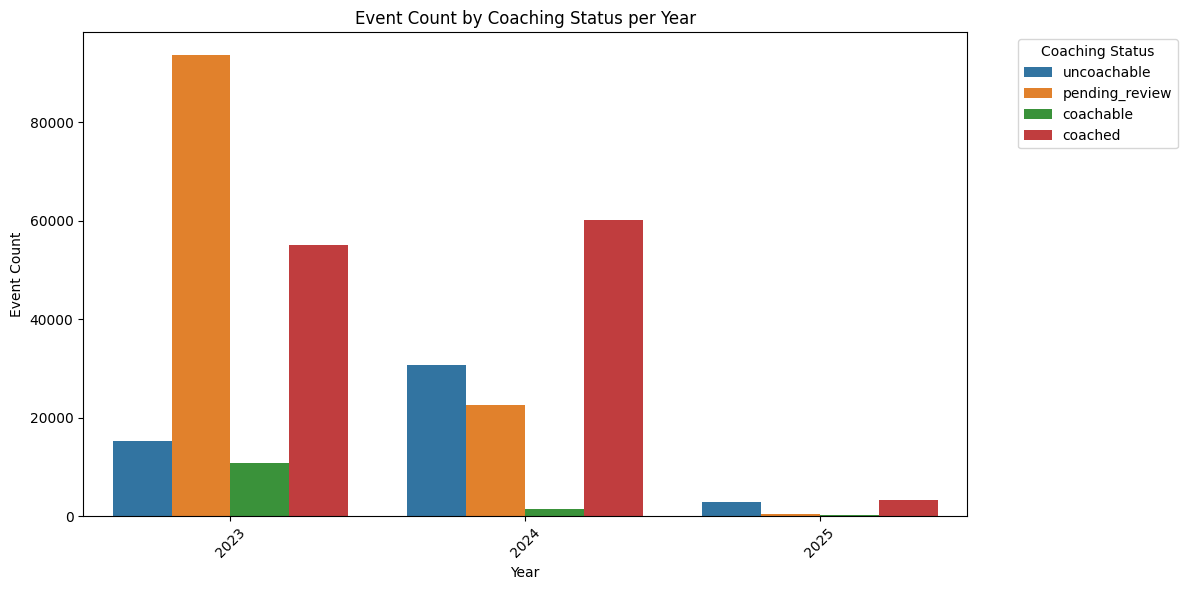

In [0]:
# count per coaching status
event_coaching_by_year = cleaned_combined_event_data.withColumn("year", date_format("trip_date", "yyyy")).groupBy("year", "coaching_status").agg(count("*").alias("event_count"))
event_coaching_by_year_pd = event_coaching_by_year.toPandas()
event_coaching_by_year_pd["year"] = event_coaching_by_year_pd["year"].astype(str)  

plt.figure(figsize=(12, 6))
sns.barplot(
    data=event_coaching_by_year_pd,
    x="year",
    y="event_count",
    hue="coaching_status", 
    order=sorted(event_coaching_by_year_pd["year"].unique()) )
plt.title("Event Count by Coaching Status per Year")
plt.xlabel("Year")
plt.ylabel("Event Count")
plt.xticks(rotation=45)
plt.legend(title="Coaching Status", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

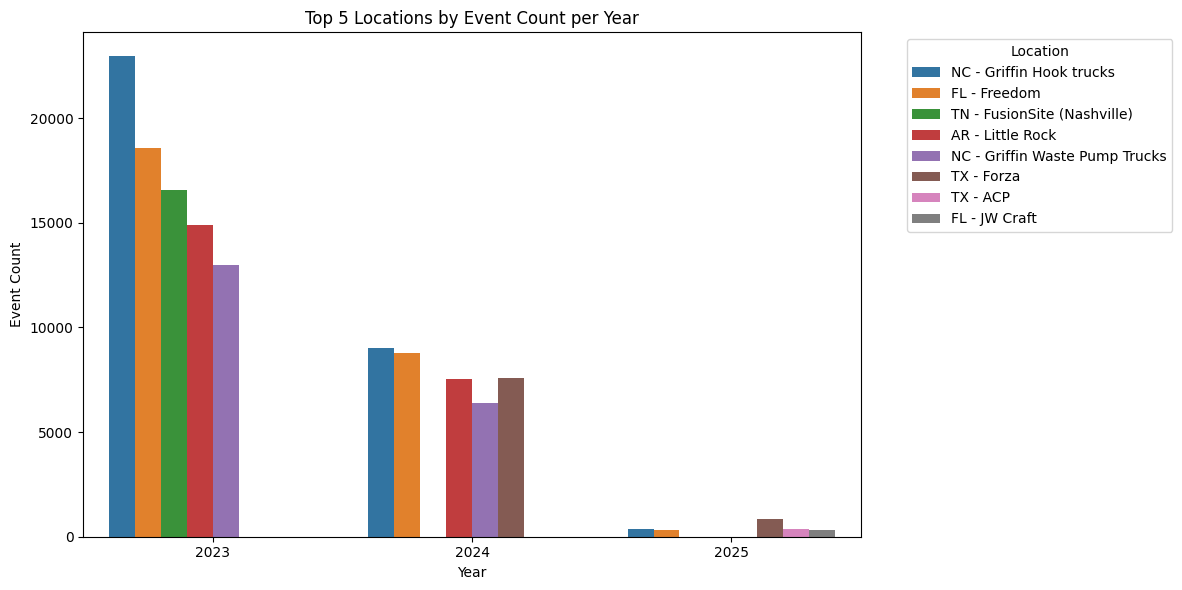

In [0]:
## top 5 Locations with highest event count per year
events_by_location_year = cleaned_combined_event_data.withColumn(
    "year", date_format("trip_date", "yyyy")
).groupBy("year", "group_name").agg(
    count("*").alias("event_count")
)

# Rank locations within each year
windowSpec = Window.partitionBy("year").orderBy(col("event_count").desc())
top5_locations_yearly = events_by_location_year.withColumn(
    "rank", rank().over(windowSpec)
).filter(col("rank") <= 5)

top5_locations_pd = top5_locations_yearly.toPandas()

top5_locations_pd["year"] = top5_locations_pd["year"].astype(str)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top5_locations_pd,
    x="year",
    y="event_count",
    hue="group_name"
)
plt.title("Top 5 Locations by Event Count per Year")
plt.xlabel("Year")
plt.ylabel("Event Count")
plt.legend(title="Location", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

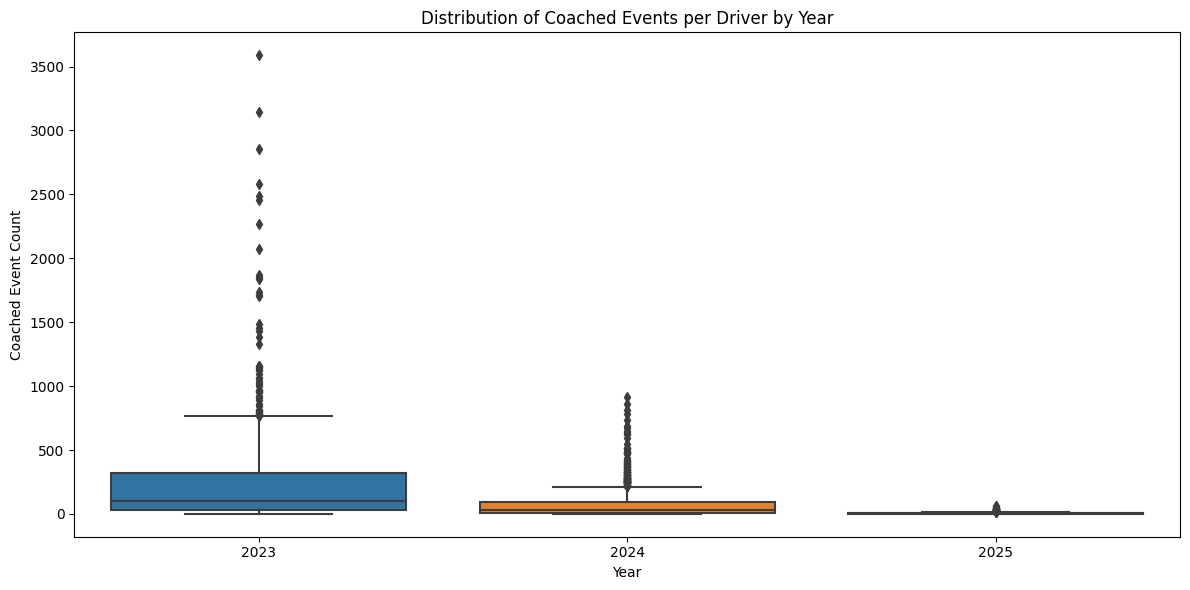

In [0]:
coached_events = cleaned_combined_event_data.filter(col("coaching_status") != "uncoachable")
coached_events_with_year = coached_events.withColumn("year", date_format("trip_date", "yyyy"))

# Group by year and driver, and count coached events
coached_per_driver_year = coached_events_with_year.groupBy("year", "driver_id").agg(
    count("*").alias("coached_event_count")
)

# Convert to Pandas for plotting
coached_per_driver_year_pd = coached_per_driver_year.toPandas()
coached_per_driver_year_pd["year"] = coached_per_driver_year_pd["year"].astype(str) 

# plotting 
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=coached_per_driver_year_pd,
    x="year",
    y="coached_event_count"
)
plt.title("Distribution of Coached Events per Driver by Year")
plt.xlabel("Year")
plt.ylabel("Coached Event Count")
plt.tight_layout()
plt.show()

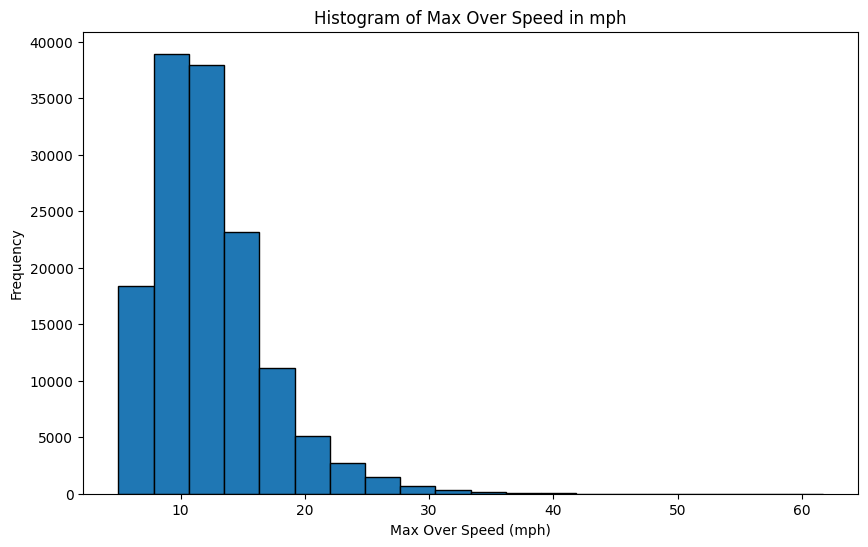

In [0]:
## Speeeding Histogram
speeding_data = cleaned_combined_event_data.filter(col("max_over_speed_in_mph").isNotNull())
speeding_pd = speeding_data.select("max_over_speed_in_mph").toPandas()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(speeding_pd["max_over_speed_in_mph"], bins=20, edgecolor='black')
plt.xlabel("Max Over Speed (mph)")
plt.ylabel("Frequency")
plt.title("Histogram of Max Over Speed in mph")
plt.show()

**Observation:**
- in overall, there is no trend that hazard events occur paticularly often in 1 month compared to other months. However, there are more hazard events happened in 2023 than 2024, this mean a lot of the sites actually pay attentiona and train the driver to be a "safer drivers" leading to lower hazard events count 

- In all 3 years 2023, 2024 and beginning of 2025, generally, speeding, cellphone, stop sign violation and tail gating are common event type appearing in all 3 years 

- in 2023, there are a lot more pending reviews, typically mean a lot more sites are not being rigorous about looking at the reviews and coaching their driver correctly

- The number significantly reduces, I believe that having a small pending review means that the driver will be less prone to making mistakes 

- The sites that have the most event count are NC - Griffin Hooks truck and Griffins Waste Pump Trucs , FL freedom, AR - Little Rocks,
- Most of the common max speeding over range is 5-15 mph (basically speeding over the speeding limit) 

### Features Preparations 
This code sections will generate features preparation columns for hazard event type. For example, we creates per-trip event counts (including total and by type) for each driver and computes 7, 15, and 30-day rolling sums to capture short- to long-term behavioral trends; we also categorizes speeding severity, tracks pending coaching reviews, and joins all event features into a summary table. This summary table will then later be joined with driver information to further understand their behaviors. We would expect to see that driver with less experience will be more likely to commmit harzard events

- `total_events_per_trip`: Total number of events recorded for a given driver on a specific trip date. This provides a measure of overall activity volume.
- `<event_type>`: Count of events of a specific type (e.g., `idling`, `harsh_braking`, etc.) for a given driver on a specific trip date. These columns are generated dynamically based on distinct values in the `type` column of the source data.
- `<event_type>_roll7d`: Rolling 7-day sum of the `<event_type>` for each driver, excluding the current trip date. This captures short-term trends in driver behavior.
- `<event_type>_roll15d`: Rolling 15-day sum of the `<event_type>` for each driver, excluding the current trip date. This helps identify mid-term behavioral patterns.
- `<event_type>_roll30d`: Rolling 30-day sum of the `<event_type>` for each driver, excluding the current trip date. Useful for understanding long-term event frequency or escalation.
- `low`: Count of speeding events during the trip date where `max_over_speed_in_mph` was less than or equal to 10 MPH. Represents low-risk speeding behavior.
- `mid`: Count of speeding events during a trip date where `max_over_speed_in_mph` was between 11 and 25 MPH. Represents moderate-risk speeding behavior.
- `high`: Count of speeding events during a trip date where `max_over_speed_in_mph` exceeded 25 MPH. Represents high-risk or severe speeding behavior.
- `low_roll7d`: Rolling 7-day sum of low-level speeding events for each driver, excluding the current trip date. Indicates recent low-risk speeding frequency.
- `mid_roll7d`: Rolling 7-day sum of mid-level speeding events for each driver, excluding the current trip date.
- `high_roll7d`: Rolling 7-day sum of high-level speeding events for each driver, excluding the current trip date.
- `low_roll15d`: Rolling 15-day sum of low-level speeding events for each driver, excluding the current trip date.
- `mid_roll15d`: Rolling 15-day sum of mid-level speeding events for each driver, excluding the current trip date.
- `high_roll15d`: Rolling 15-day sum of high-level speeding events for each driver, excluding the current trip date.
- `low_roll30d`: Rolling 30-day sum of low-level speeding events for each driver, excluding the current trip date.
- `mid_roll30d`: Rolling 30-day sum of mid-level speeding events for each driver, excluding the current trip date.
- `high_roll30d`: Rolling 30-day sum of high-level speeding events for each driver, excluding the current trip date.
- `prev_pending_review_count`: Number of coaching events with `coaching_status = 'pending_review'` recorded on the **previous trip** for the same driver. Used to assess whether recent coaching needs correlate with other driving behaviors or risks.



In [0]:
# create counts for all of the events 
target_event_types = [row["type"] for row in cleaned_combined_event_data.select("type").distinct().orderBy("type").collect()]

# Count all events per trip per driver
events_per_trip_per_driver = cleaned_combined_event_data.groupBy("driver_id", "trip_date").agg(
    count("*").alias("total_events_per_trip")
)
event_counts_by_type = cleaned_combined_event_data.groupBy("driver_id", "trip_date") \
    .pivot("type", target_event_types) \
    .agg(count("*")) \
    .fillna(0)

events_df = event_counts_by_type.join(
    events_per_trip_per_driver, on=["driver_id", "trip_date"], how="left"
)

# create rolling window for 7 days
events_df=events_df.withColumn("trip_ts", unix_timestamp(to_timestamp("trip_date")))

# Define time-based windows (in seconds) for 7, 15, and 30 days.
rolling_window_days_7 = Window.partitionBy("driver_id") \
    .orderBy("trip_ts") \
    .rangeBetween(-7 * 86400, -1)

rolling_window_days_15 = Window.partitionBy("driver_id") \
    .orderBy("trip_ts") \
    .rangeBetween(-15 * 86400, -1)

rolling_window_days_30 = Window.partitionBy("driver_id") \
    .orderBy("trip_ts") \
    .rangeBetween(-30 * 86400, -1)

# Step 3: Apply rolling sum for each event column
event_cols = [col_name for col_name in events_df.columns if col_name not in ["driver_id", "trip_date"]]

for col_name in event_cols:
    events_df = events_df.withColumn(f"{col_name}_roll7d", sum(col(col_name)).over(rolling_window_days_7))
    events_df = events_df.withColumn(f"{col_name}_roll15d", sum(col(col_name)).over(rolling_window_days_15))
    events_df = events_df.withColumn(f"{col_name}_roll30d", sum(col(col_name)).over(rolling_window_days_30))

events_summary = events_df.fillna(0, subset=[f"{col}_roll{w}d" for col in event_cols for w in [7, 15, 30]]).drop("trip_ts")

events_summary.show()

+---------+----------+------------------+----------+-----+-----------+-----------------------------+----------+-------------------------+------------+---------+---------------+---------------------------+-------------------+--------+-------------------+----------+------------------+---------------------+-------------------------+--------------------------+--------------------------+-----------------+------------------+------------------+------------+-------------+-------------+------------------+-------------------+-------------------+------------------------------------+-------------------------------------+-------------------------------------+-----------------+------------------+------------------+--------------------------------+---------------------------------+---------------------------------+-------------------+--------------------+--------------------+----------------+-----------------+-----------------+----------------------+-----------------------+-----------------------+---

In [0]:
# create a speed bins 
speed_categorized_df = cleaned_combined_event_data.withColumn(
    "speed_type",
    when((col("type") == "speeding") & (col("max_over_speed_in_mph") <= 10), "low")
    .when((col("type") == "speeding") & (col("max_over_speed_in_mph") > 10) & (col("max_over_speed_in_mph") <= 25), "mid")
    .when((col("type") == "speeding") & (col("max_over_speed_in_mph") > 25), "high")
    .otherwise(None)  # ignore non-speeding events
)

#Filter only rows where speed_type is not null (i.e., actual speeding events)
speed_events_only = speed_categorized_df.filter(col("speed_type").isNotNull())

#roup by driver_id and trip_date, then pivot speed_type and count
speed_type_counts = speed_events_only.groupBy("driver_id", "trip_date") \
    .pivot("speed_type", ["low", "mid", "high"]) \
    .agg(count("*")) \
    .fillna(0)
speed_type_counts=speed_type_counts.withColumn("trip_ts", unix_timestamp(to_timestamp("trip_date")))

for col_name in ["low", "mid", "high"]:
    speed_type_counts = speed_type_counts.withColumn(f"{col_name}_roll7d", sum(col(col_name)).over(rolling_window_days_7))
    speed_type_counts = speed_type_counts.withColumn(f"{col_name}_roll15d", sum(col(col_name)).over(rolling_window_days_15))
    speed_type_counts = speed_type_counts.withColumn(f"{col_name}_roll30d", sum(col(col_name)).over(rolling_window_days_30))

#fFill nulls with 0 for early trips (first few with fewer than 7/15/30 days)
rolling_cols = [f"{s}_roll{w}d" for s in ["low", "mid", "high"] for w in [7, 15, 30]]
speed_type_counts = speed_type_counts.fillna(0, subset=rolling_cols).drop("trip_ts")

# drop trip_ts column
speed_type_counts.show()

+---------+----------+---+---+----+----------+-----------+-----------+----------+-----------+-----------+-----------+------------+------------+
|driver_id| trip_date|low|mid|high|low_roll7d|low_roll15d|low_roll30d|mid_roll7d|mid_roll15d|mid_roll30d|high_roll7d|high_roll15d|high_roll30d|
+---------+----------+---+---+----+----------+-----------+-----------+----------+-----------+-----------+-----------+------------+------------+
|  67876.0|2023-01-05|  2|  2|   0|         0|          0|          0|         0|          0|          0|          0|           0|           0|
|  67876.0|2023-01-06|  2|  0|   0|         2|          2|          2|         2|          2|          2|          0|           0|           0|
|  67876.0|2023-01-07|  4|  5|   0|         4|          4|          4|         2|          2|          2|          0|           0|           0|
|  67876.0|2023-01-09| 10|  5|   0|         8|          8|          8|         7|          7|          7|          0|           0|      

In [0]:
# count number of pending review coaching status
pending_review_df = cleaned_combined_event_data.filter(col("coaching_status") == "pending_review").groupBy("driver_id", "trip_date").agg(count("*").alias("pending_review_count"))
window_spec = Window.partitionBy("driver_id").orderBy("trip_date")
pending_review_df_with_lag = pending_review_df.withColumn(
    "prev_pending_review_count",
    lag("pending_review_count", 1).over(window_spec)
)
# drop pending_review_count column
pending_review_df = pending_review_df_with_lag.drop("pending_review_count").fillna(0)
pending_review_df.show()

+---------+----------+-------------------------+
|driver_id| trip_date|prev_pending_review_count|
+---------+----------+-------------------------+
|  67876.0|2023-01-05|                        0|
|  67876.0|2023-01-06|                        7|
|  67876.0|2023-01-07|                        1|
|  67876.0|2023-01-12|                        9|
|  67876.0|2023-01-13|                        5|
|  67876.0|2023-01-16|                       11|
|  67876.0|2023-01-19|                        3|
|  67876.0|2023-01-20|                        2|
|  67876.0|2023-01-23|                        6|
|  67876.0|2023-01-25|                        1|
|  67876.0|2023-01-30|                        1|
|  67876.0|2023-02-14|                        1|
|  67876.0|2023-02-16|                        1|
|  67876.0|2023-02-17|                        1|
|  67876.0|2023-03-13|                        1|
|  67876.0|2023-04-03|                        1|
|  67876.0|2023-07-13|                        2|
|  67876.0|2023-07-3

In [0]:
# join speed_type_counts and events_summary
events_summary= events_summary.join(pending_review_df, on=["driver_id",  "trip_date"], how="left")
events_summary= events_summary.join(speed_type_counts, on=["driver_id", "trip_date"], how="left").cache()
events_summary.show()

+---------+----------+------------------+----------+-----+-----------+-----------------------------+----------+-------------------------+------------+---------+---------------+---------------------------+-------------------+--------+-------------------+----------+------------------+---------------------+-------------------------+--------------------------+--------------------------+-----------------+------------------+------------------+------------+-------------+-------------+------------------+-------------------+-------------------+------------------------------------+-------------------------------------+-------------------------------------+-----------------+------------------+------------------+--------------------------------+---------------------------------+---------------------------------+-------------------+--------------------+--------------------+----------------+-----------------+-----------------+----------------------+-----------------------+-----------------------+---

#### `data_driving_periods_w_vehicle_map.csv`
Questions: 
- what is the total driving distance distribution or total driving minutes distribution with average and median ( the trip total would calcualte based on agg driver_id, vehicle_id and start_date)
- What are typical driving durations and distances? summary statistics
- What’s the trend over time (daily, weekly)? 
- Which day of the week or month has the most driving activity?
-  What’s the average speed per trip?

In [0]:
# total driving distance distributions with average and median  per driver id, vehicle id and trip date 
# Group by trip (driver_id, vehicle_id, start_date)
trip_summary = cleaned_driving_period.groupBy("driver_id", "vehicle_id", "trip_date").agg(
    sum("driving_distance").alias("trip_total_distance")
    , sum("minutes_driving").alias("trip_total_minutes")
)

trip_summary_pd = trip_summary.toPandas()

trip_summary_pd

,driver_id,vehicle_id,trip_date,trip_total_distance,trip_total_minutes
0,3757580.0,1292577,2023-07-18,257.6,332.450000
1,3890083.0,1177252,2023-07-18,22.9,48.500000
2,3735391.0,1032413,2023-07-17,154.6,442.700000
3,4036812.0,1123091,2023-07-17,116.6,377.150000
4,3749439.0,1086397,2023-07-15,57.3,77.300000
...,...,...,...,...,...
216937,4132041.0,1136157,2023-07-28,131.0,356.783333
216938,3796799.0,1202212,2023-07-28,162.6,441.650000
216939,3785370.0,1123157,2023-07-27,116.7,347.566667
216940,4156518.0,1086414,2023-07-26,102.3,265.766667


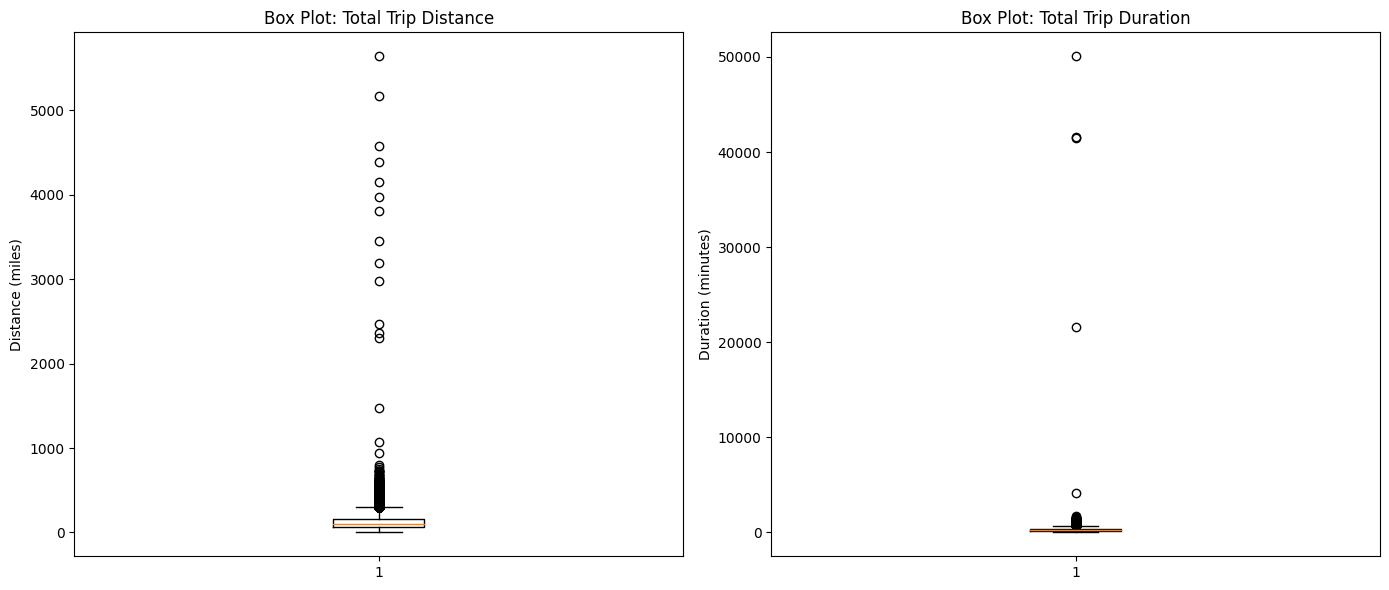

In [0]:
# Create side-by-side box plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for total trip distance
axs[0].boxplot(trip_summary_pd["trip_total_distance"].dropna(), vert=True)
axs[0].set_title("Box Plot: Total Trip Distance")
axs[0].set_ylabel("Distance (miles)")

# Boxplot for total trip minutes
axs[1].boxplot(trip_summary_pd["trip_total_minutes"].dropna(), vert=True)
axs[1].set_title("Box Plot: Total Trip Duration")
axs[1].set_ylabel("Duration (minutes)")

plt.tight_layout()
plt.show()


In [0]:
# typical driving durations and distances for every shift (per driver id, per vehicle and start date)
trip_duration_dist = trip_summary.select("trip_total_distance", "trip_total_minutes")

trip_duration_dist.describe(["trip_total_distance", "trip_total_minutes"]).show()


+-------+-------------------+------------------+
|summary|trip_total_distance|trip_total_minutes|
+-------+-------------------+------------------+
|  count|             216942|            216942|
|   mean| 112.64412008739497| 276.2331177611235|
| stddev|  78.14519358810486|229.90081323473575|
|    min|                0.1|              0.05|
|    max|  5641.799999999998|          50080.45|
+-------+-------------------+------------------+



+----------+----------+------------------+
| trip_date|trip_count|    total_distance|
+----------+----------+------------------+
|2023-01-01|        68|341.29999999999995|
|2023-01-02|       140|1318.6000000000001|
|2023-01-03|       947| 7786.700000000007|
|2023-01-04|      1105| 8753.400000000001|
|2023-01-05|      1075|  8964.00000000001|
|2023-01-06|      1078| 8579.200000000008|
|2023-01-07|       146|1312.3000000000002|
|2023-01-08|        59| 732.2999999999996|
|2023-01-09|      1033| 8742.300000000001|
|2023-01-10|       896| 7020.500000000018|
|2023-01-11|      1002| 7719.600000000005|
|2023-01-12|       982| 7352.200000000004|
|2023-01-13|       808| 6953.100000000011|
|2023-01-14|        74| 707.9000000000003|
|2023-01-15|        40|291.19999999999993|
|2023-01-16|      1032| 8885.899999999998|
|2023-01-17|      1053| 8570.500000000002|
|2023-01-18|      1095| 8719.400000000012|
|2023-01-19|      1090| 8226.600000000017|
|2023-01-20|       919|  7350.20000000001|
+----------

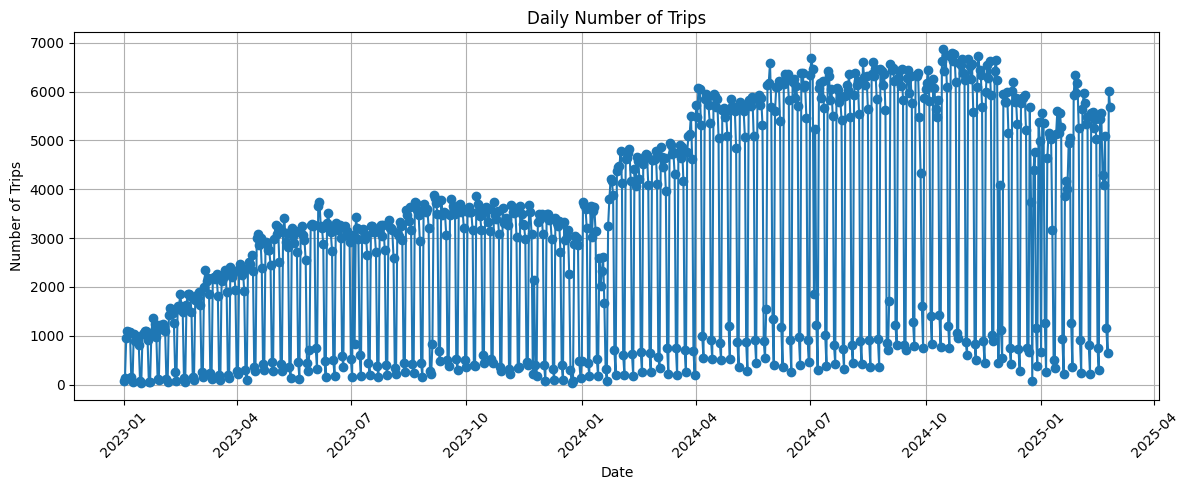

In [0]:
## Trend over time (daily, weekly)
# Daily trend
daily_trend = cleaned_driving_period.groupBy("trip_date").agg(
    count("*").alias("trip_count"),
    sum("driving_distance").alias("total_distance")
).orderBy("trip_date")

daily_trend.show()
# Convert daily trend to pandas
daily_trend_pd = daily_trend.toPandas()

# Line plot of trip count
plt.figure(figsize=(12, 5))
plt.plot(daily_trend_pd["trip_date"], daily_trend_pd["trip_count"], marker='o')
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.title("Daily Number of Trips")
plt.grid(True)
plt.tight_layout()
plt.show()


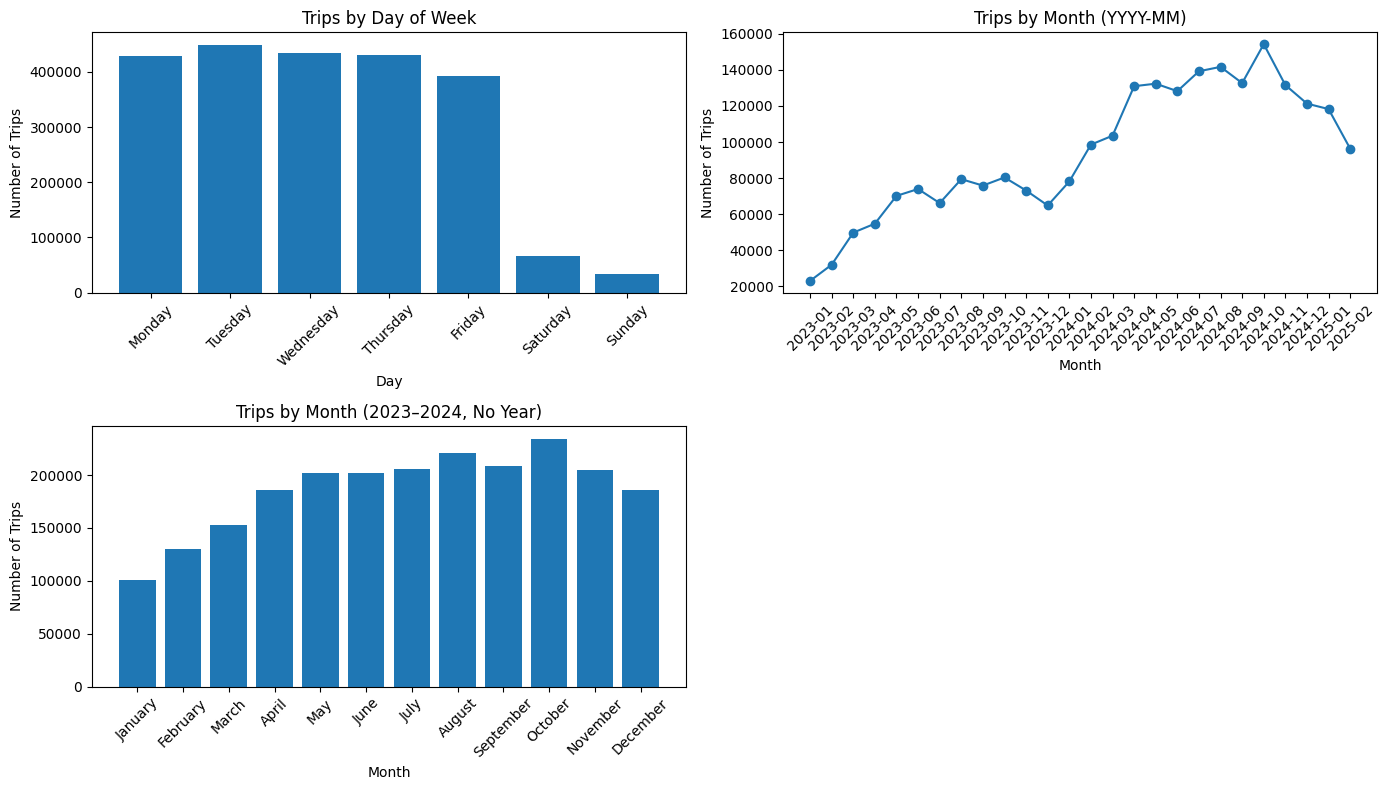

In [0]:
## Most driving activities 
day_of_week_summary = cleaned_driving_period.withColumn(
    "day_of_week", date_format("trip_date", "EEEE")  # Full weekday name
).groupBy("day_of_week").agg(
    count("*").alias("trip_count"),
    sum("driving_distance").alias("total_distance")
).orderBy("trip_count", ascending=False)

month_summary = cleaned_driving_period.withColumn(
    "month", date_format("trip_date", "yyyy-MM")
).groupBy("month").agg(
    count("*").alias("trip_count"),
    sum("driving_distance").alias("total_distance")
).orderBy("month")

# month trends for 2023-2024
filtered_driving_period = cleaned_driving_period.filter(
    (year("trip_date") >= 2023) & (year("trip_date") <= 2024)
)

day_of_week_summary = filtered_driving_period.withColumn(
    "day_of_week", date_format("trip_date", "EEEE")
).groupBy("day_of_week").agg(
    count("*").alias("trip_count"),
    sum("driving_distance").alias("total_distance")
)

month_name_summary = filtered_driving_period.withColumn(
    "month_name", date_format("trip_date", "MMMM")
).groupBy("month_name").agg(
    count("*").alias("trip_count")
)

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# Convert to pandas
dow_pd = day_of_week_summary.toPandas()
month_pd = month_summary.toPandas()
month_name_pd = month_name_summary.toPandas().set_index("month_name").reindex(month_order).reset_index()


# Plot: Day of week
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_pd = dow_pd.set_index('day_of_week').reindex(ordered_days).reset_index()
axs[0, 0].bar(dow_pd["day_of_week"], dow_pd["trip_count"])
axs[0, 0].set_title("Trips by Day of Week")
axs[0, 0].set_xlabel("Day")
axs[0, 0].set_ylabel("Number of Trips")
axs[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Month (with year)
axs[0, 1].plot(month_pd["month"], month_pd["trip_count"], marker='o')
axs[0, 1].set_title("Trips by Month (YYYY-MM)")
axs[0, 1].set_xlabel("Month")
axs[0, 1].set_ylabel("Number of Trips")
axs[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Month (no year)
axs[1, 0].bar(month_name_pd["month_name"], month_name_pd["trip_count"])
axs[1, 0].set_title("Trips by Month (2023–2024, No Year)")
axs[1, 0].set_xlabel("Month")
axs[1, 0].set_ylabel("Number of Trips")
axs[1, 0].tick_params(axis='x', rotation=45)

# Hide the empty 4th subplot (bottom-right)
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()


**EDA Observation**: 

- Typically, each driver have to drive around 112 miles per trip with 276 minutes  driven per day. However, there are some outliers with more than 1000 miles driven in a single trip.
- Compared to 2023, 2024 have a lots more trips per day; notes, if driver change to another vehicle within a day, it would be counted as a new trip.
- From "Trips by Day of Week", most of the driving activities happened during weekday 
- From "Trips By Month", the number of trips are significantly lowered in "January",  "February"  and "March"; the remaining months trip count stay relatively stable.
- As time goes on, the number of trips increases, this mean the company gains some business in 2024 




#### Features Preparation: 
This section is used to understand the driver's driving behaviors, especially learning about trip frequency, recency, speeding behavior and driving patterns. We include information that reflect historical driving behavior and short term deviation/trends of a particular driver. 

- Trip Volume + Recency Features: Tracks total trip counts, rolling trip frequencies (7-day, 30-day), and time since last trip for behavioral intensity modeling.
- Trip Speed Analysis: Calculates average speed per trip and its lagged, rolling trends to detect driving consistency or abrupt changes.
- Rolling Distance/Duration Totals: Aggregates trip distance and time over time-based windows (7/15/30 days) to understand recent activity levels.
- Temporal Normalization: Uses log(trip count) and days since first trip to normalize metrics for drivers with different tenure.
- Change Detection: Captures change in driving distance and time relative to the previous trip, helping spot anomalies or behavior shifts.


In [0]:
# get number of trips that a driver have done 
all_driver_trip_count = cleaned_driving_period.select("driver_id", "trip_date").distinct().groupby("driver_id").agg(count("*").alias("driver_total_trip_count"), min("trip_date").alias("first_driving_date"))
# create a log driver total trips count

all_driver_trip_count = all_driver_trip_count.withColumn("driver_log_trip_count", F.log(col("driver_total_trip_count")))
all_driver_trip_count.show()


+---------+-----------------------+------------------+---------------------+
|driver_id|driver_total_trip_count|first_driving_date|driver_log_trip_count|
+---------+-----------------------+------------------+---------------------+
|3886528.0|                    530|        2023-02-13|    6.272877006546167|
|4280275.0|                     24|        2023-08-21|   3.1780538303479458|
|5172625.0|                     58|        2024-10-11|    4.060443010546419|
|3848275.0|                    182|        2023-02-06|    5.204006687076795|
|4699590.0|                    194|        2024-04-03|    5.267858159063328|
|5159610.0|                    131|        2024-10-04|    4.875197323201151|
|4553943.0|                    123|        2024-01-29|    4.812184355372417|
|5165674.0|                     51|        2024-10-10|   3.9318256327243257|
|5129520.0|                      5|        2024-09-26|   1.6094379124341003|
|4688926.0|                     12|        2024-03-27|   2.4849066497880004|

In [0]:
driver_trip_count = cleaned_driving_period.select("driver_id", "trip_date").distinct()
# Convert trip_date to timestamp for time-based windowing
driver_trip_count = driver_trip_count.withColumn("trip_ts", unix_timestamp(to_timestamp("trip_date")))

# join with driver count
driver_trip_count = driver_trip_count.join(all_driver_trip_count, on="driver_id", how='left')

# Define a range-based window: 7 days before current trip date (exclude current row)
rolling_7day_window = (
    Window
    .partitionBy("driver_id")
    .orderBy("trip_ts")
    .rangeBetween(-7 * 86400, -1)  # seconds in 7 days, exclude current
)

rolling_30d_window = Window.partitionBy("driver_id") \
    .orderBy("trip_ts") \
    .rangeBetween(-30 * 86400, -1)

# Compute total trips and high-speed trips in the last 7 and 30 days
driver_trip_count = driver_trip_count.withColumn(
    "rolling_7day_trip_count",
    count("*").over(rolling_7day_window)
).withColumn(
    "rolling_30day_trip_count", count("*").over(rolling_30d_window))

driver_trip_count = driver_trip_count.withColumn(
    "previous_trip_date",
    lag("trip_date", 1).over(Window.partitionBy("driver_id").orderBy("trip_date"))
)

# Calculate the day difference between current and previous trip
driver_trip_count = driver_trip_count.withColumn(
    "days_since_last_trip",
    datediff(col("trip_date"), col("previous_trip_date"))
)

# the number of days the driver have been driving 
driver_trip_count = driver_trip_count.withColumn("driving_year_since_first_trip", (datediff(col("trip_date"), col("first_driving_date")))/365)
driver_trip_count.sort("driver_id", col("trip_date").desc()).show()

+---------+----------+----------+-----------------------+------------------+---------------------+-----------------------+------------------------+------------------+--------------------+-----------------------------+
|driver_id| trip_date|   trip_ts|driver_total_trip_count|first_driving_date|driver_log_trip_count|rolling_7day_trip_count|rolling_30day_trip_count|previous_trip_date|days_since_last_trip|driving_year_since_first_trip|
+---------+----------+----------+-----------------------+------------------+---------------------+-----------------------+------------------------+------------------+--------------------+-----------------------------+
|  67876.0|2024-12-31|1735603200|                    401|        2023-01-05|    5.993961427306569|                      2|                      15|        2024-12-30|                   1|            1.989041095890411|
|  67876.0|2024-12-30|1735516800|                    401|        2023-01-05|    5.993961427306569|                      1|      

In [0]:

# average trip speed per trip date per driver id and vehicle 
trip_avg_speed = (
    cleaned_driving_period
    .groupBy("driver_id", "trip_date")
    .agg(
        sum("driving_distance").alias("trip_date_distance"),
        sum("minutes_driving").alias("trip_date_minutes"), 
        count("*").alias("trip_date_count")
    )
    .withColumn("trip_date_avg_speed_mph", round(col("trip_date_distance") / (col("trip_date_minutes") / 60), 2))
)

# create -1 lagged for trip_avg_speed_mph 
driver_trip_window = (
    Window
    .partitionBy("driver_id")
    .orderBy("trip_date")
)

# Add -1 lagged column for previous trip's average speed
trip_avg_speed = trip_avg_speed.withColumn(
    "previous_trip_date_avg_speed_mph",
    lag("trip_date_avg_speed_mph", 1).over(driver_trip_window)
)

# rolling average speed for 7, 15, and 30 trips
rolling_window_7 = Window.partitionBy("driver_id") \
                         .orderBy(col("trip_date").cast("timestamp")) \
                         .rowsBetween(-7, -1)

rolling_window_15 = Window.partitionBy("driver_id") \
                          .orderBy(col("trip_date").cast("timestamp")) \
                          .rowsBetween(-15, -1)

rolling_window_30 = Window.partitionBy("driver_id") \
                          .orderBy(col("trip_date").cast("timestamp")) \
                          .rowsBetween(-30, -1)

trip_avg_speed = (
    trip_avg_speed
    .withColumn("rolling_7trip_avg_speed_mph", avg("trip_date_avg_speed_mph").over(rolling_window_7))
    .withColumn("rolling_15trip_avg_speed_mph", avg("trip_date_avg_speed_mph").over(rolling_window_15))
    .withColumn("rolling_30trip_avg_speed_mph", avg("trip_date_avg_speed_mph").over(rolling_window_30))
    .withColumn("prev_trip_date_distance", lag("trip_date_distance", 1).over(driver_trip_window))
    .withColumn("prev_trip_date_minutes", lag("trip_date_minutes", 1).over(driver_trip_window))
    .withColumn("change_in_distance", col("trip_date_distance") - col("prev_trip_date_distance"))
    .withColumn("change_in_minutes", col("trip_date_minutes") - col("prev_trip_date_minutes"))
)

# create trip_ts
trip_avg_speed=trip_avg_speed.withColumn("trip_ts", unix_timestamp(to_timestamp("trip_date")))

# Define time-based windows (in seconds) for 7, 15, and 30 days.
rolling_window_days_7 = Window.partitionBy("driver_id") \
    .orderBy("trip_ts") \
    .rangeBetween(-7 * 86400, -1)

rolling_window_days_15 = Window.partitionBy("driver_id") \
    .orderBy("trip_ts") \
    .rangeBetween(-15 * 86400, -1)

rolling_window_days_30 = Window.partitionBy("driver_id") \
    .orderBy("trip_ts") \
    .rangeBetween(-30 * 86400, -1)

trip_avg_speed = (
    trip_avg_speed
    .withColumn("rolling_7day_total_distance", sum("trip_date_distance").over(rolling_window_days_7))
    .withColumn("rolling_7day_total_minutes", sum("trip_date_minutes").over(rolling_window_days_7))
    .withColumn("rolling_15day_total_distance", sum("trip_date_distance").over(rolling_window_days_15))
    .withColumn("rolling_15day_total_minutes", sum("trip_date_minutes").over(rolling_window_days_15))
    .withColumn("rolling_30day_total_distance", sum("trip_date_distance").over(rolling_window_days_30))
    .withColumn("rolling_30day_total_minutes", sum("trip_date_minutes").over(rolling_window_days_30))
)

# drop trip_ts 
trip_avg_speed = trip_avg_speed.drop("trip_ts")

trip_avg_speed = trip_avg_speed.sort("driver_id", col("trip_date").desc())
trip_avg_speed.show()

+---------+----------+------------------+------------------+---------------+-----------------------+--------------------------------+---------------------------+----------------------------+----------------------------+-----------------------+----------------------+-------------------+-------------------+---------------------------+--------------------------+----------------------------+---------------------------+----------------------------+---------------------------+
|driver_id| trip_date|trip_date_distance| trip_date_minutes|trip_date_count|trip_date_avg_speed_mph|previous_trip_date_avg_speed_mph|rolling_7trip_avg_speed_mph|rolling_15trip_avg_speed_mph|rolling_30trip_avg_speed_mph|prev_trip_date_distance|prev_trip_date_minutes| change_in_distance|  change_in_minutes|rolling_7day_total_distance|rolling_7day_total_minutes|rolling_15day_total_distance|rolling_15day_total_minutes|rolling_30day_total_distance|rolling_30day_total_minutes|
+---------+----------+------------------+-------

In [0]:
# joined trip_avg_speed and driver_trip_count
driving_trips_agg = driver_trip_count.join(trip_avg_speed, on=["driver_id", "trip_date"], how="left").cache()
print(driving_trips_agg.printSchema())
driving_trips_agg.show()

root
 |-- driver_id: double (nullable = true)
 |-- trip_date: date (nullable = true)
 |-- trip_ts: long (nullable = true)
 |-- driver_total_trip_count: long (nullable = true)
 |-- first_driving_date: date (nullable = true)
 |-- driver_log_trip_count: double (nullable = true)
 |-- rolling_7day_trip_count: long (nullable = false)
 |-- rolling_30day_trip_count: long (nullable = false)
 |-- previous_trip_date: date (nullable = true)
 |-- days_since_last_trip: integer (nullable = true)
 |-- driving_year_since_first_trip: double (nullable = true)
 |-- trip_date_distance: double (nullable = true)
 |-- trip_date_minutes: double (nullable = true)
 |-- trip_date_count: long (nullable = true)
 |-- trip_date_avg_speed_mph: double (nullable = true)
 |-- previous_trip_date_avg_speed_mph: double (nullable = true)
 |-- rolling_7trip_avg_speed_mph: double (nullable = true)
 |-- rolling_15trip_avg_speed_mph: double (nullable = true)
 |-- rolling_30trip_avg_speed_mph: double (nullable = true)
 |-- prev_t

#### `data_inspections_w_vehicle_map.csv`  - only considered pretrip 
Questions: 
- What are the overall distribution of inspection status 
- which vehicles are constantly showing problem (open+resolved/inspection count)
- monthly trend of open/resolved issues 
- does some locations riskier than others (by states)


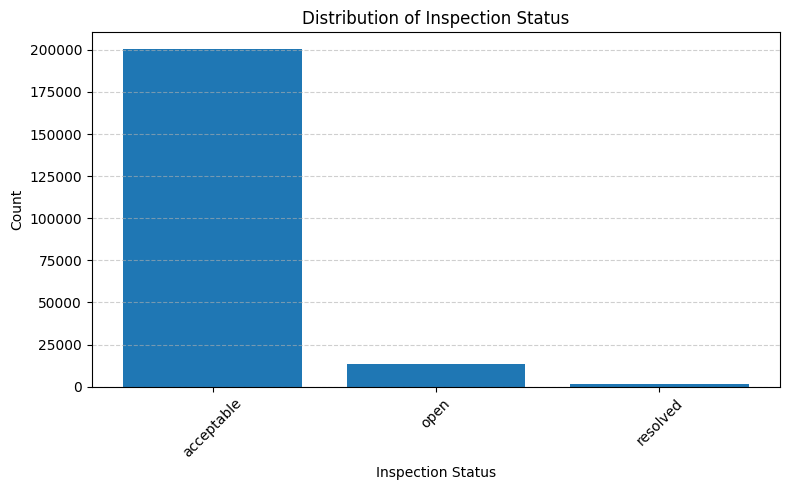

In [0]:
# Distribution of inspection data
inspection_status_dist = (
    cleaned_inspection_data
    .groupBy("inspection_status")
    .agg(count("*").alias("count"))
    .orderBy("count", ascending=False)
)

# Convert to Pandas
inspection_status_pd = inspection_status_dist.toPandas()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(inspection_status_pd["inspection_status"], inspection_status_pd["count"])
plt.xlabel("Inspection Status")
plt.ylabel("Count")
plt.title("Distribution of Inspection Status")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


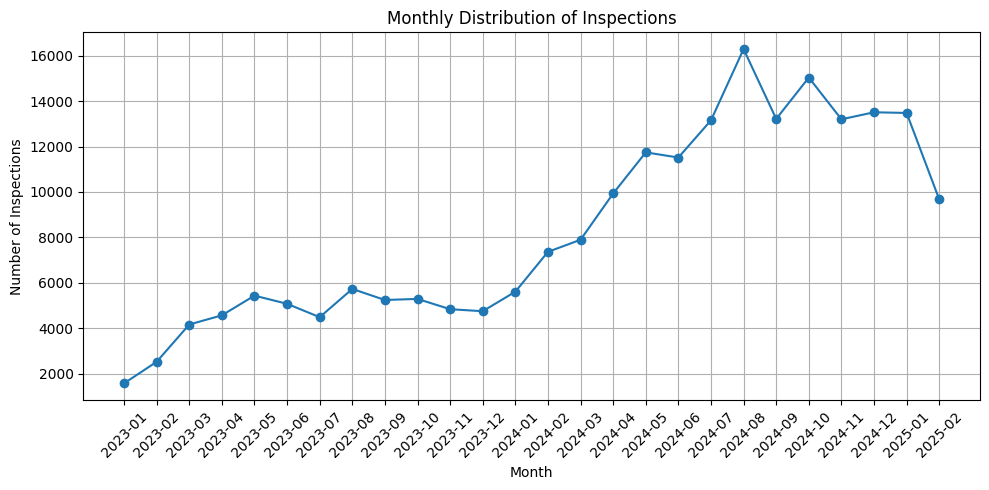

In [0]:
from pyspark.sql.functions import date_format, count

# Extract "YYYY-MM" from date
inspection_by_month = (
    cleaned_inspection_data
    .withColumn("month", date_format("date", "yyyy-MM"))
    .groupBy("month")
    .agg(count("*").alias("inspection_count"))
    .orderBy("month")
)

inspection_by_month_pd = inspection_by_month.toPandas()

plt.figure(figsize=(10, 5))
plt.plot(inspection_by_month_pd["month"], inspection_by_month_pd["inspection_count"], marker='o')
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Number of Inspections")
plt.title("Monthly Distribution of Inspections")
plt.grid(True)
plt.tight_layout()
plt.show()

In [0]:
# Vehicles with frequent issues (open + resolved) / total inspections
# Flag problem inspections
vehicle_issue_stats = (
    cleaned_inspection_data.withColumn(
        "is_problem", when(col("inspection_status").isin("open", "resolved"), 1).otherwise(0)
    )
    .groupBy("vehicle_id")
    .agg(
        count("*").alias("total_inspections"),
        sum("is_problem").alias("problem_count")
    )
    .withColumn("problem_ratio", col("problem_count") / col("total_inspections"))
    .orderBy(col("problem_ratio").desc())
)

vehicle_issue_stats.show()


+----------+-----------------+-------------+------------------+
|vehicle_id|total_inspections|problem_count|     problem_ratio|
+----------+-----------------+-------------+------------------+
|   1123080|                5|            5|               1.0|
|   1881183|                1|            1|               1.0|
|   1879759|                3|            3|               1.0|
|   1123190|               14|           14|               1.0|
|   1883744|                1|            1|               1.0|
|   1163484|                1|            1|               1.0|
|   1883800|                1|            1|               1.0|
|   1881281|                3|            3|               1.0|
|   1163492|                1|            1|               1.0|
|   1884066|                1|            1|               1.0|
|   1123204|                2|            2|               1.0|
|   1123188|               39|           35|0.8974358974358975|
|   1123195|               36|          

This problem ratio of 1 tells us that a lot of the time, driver dont confirm to regular inspection but only wrote inspections when there is something wrong occureed. Therefore, to include the fail rate of the car, we would calculate the fail rate per vehicle by taking problem counts(open+resolved)/number of driving that the car have already had

Originally, I want to include the inspection "acceptable" as a metric because if you inspect your car daily, you should theoretically minimize any car-related accidents. However, the way how the driver logs in inspection is not the most reliable since they would log in for the sake of logging. Therefore, I am only considered the case when there are "open" or "resolved" issues 

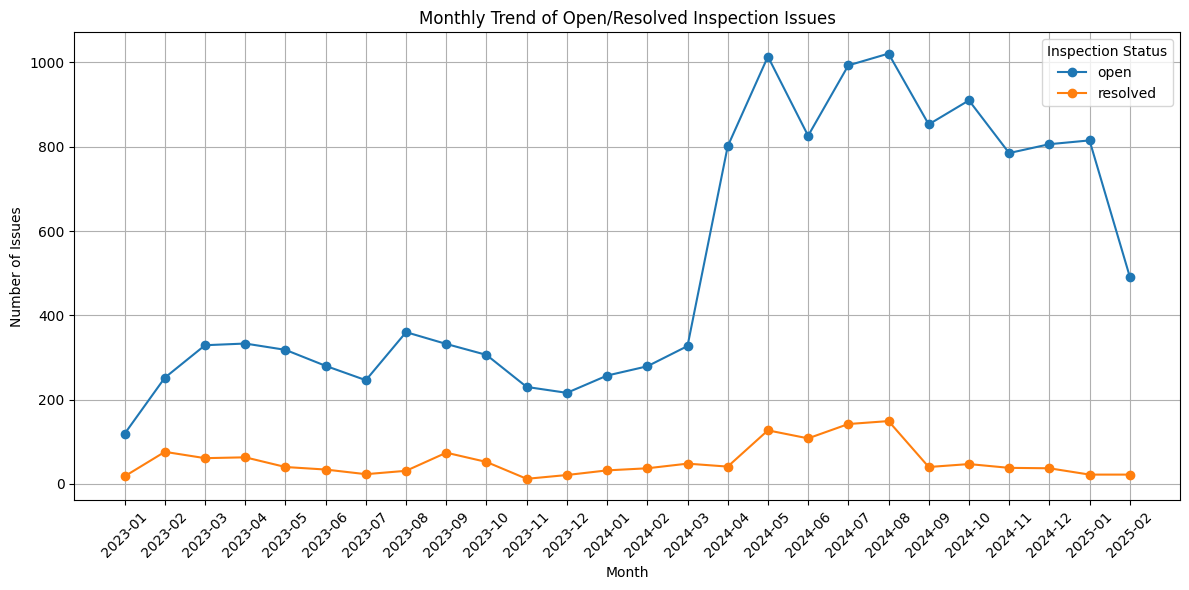

In [0]:
# extract year-month
monthly_issues = (
    cleaned_inspection_data
    .filter(col("inspection_status").isin("open", "resolved"))
    .withColumn("year_month", date_format(col("date"), "yyyy-MM"))
    .groupBy("year_month", "inspection_status")
    .agg(count("*").alias("issue_count"))
    .orderBy("year_month", "inspection_status")
)

monthly_issues_pd = monthly_issues.toPandas()
# Pivot the data so each inspection_status becomes a column
pivoted = monthly_issues_pd.pivot(index="year_month", columns="inspection_status", values="issue_count").fillna(0)
pivoted = pivoted.sort_index()  # Ensure chronological order

plt.figure(figsize=(12, 6))
for status in pivoted.columns:
    plt.plot(pivoted.index, pivoted[status], label=status, marker='o')

plt.xlabel("Month")
plt.ylabel("Number of Issues")
plt.title("Monthly Trend of Open/Resolved Inspection Issues")
plt.xticks(rotation=45)
plt.legend(title="Inspection Status")
plt.grid(True)
plt.tight_layout()
plt.show()


**EDA Observations:**
- There are significantly more inspections marked as "acceptable" compared to "open" or "resolved." While this generally makes sense—since vehicles are expected to be in good condition before drivers begin their shifts—the large discrepancy raises concerns about possible fraud or drivers rushing through inspections just to start their routes.

- Vendor compliance with vehicle inspections appears to have increased in 2024 compared to 2023. However, it's hard to determine whether these inspections were performed thoroughly or just checked off without careful review.


#### Features generations for Inspections.
The goal of this feature engineering is to capture vehicle health, maintenance frequency, and recent inspection history — all of which are critical indicators of vehicle safety and risk exposure

Columns Created: 
- `num_inspections_per_trip`: Total number of inspection records for a vehicle on a given date. Represents how many inspections were conducted during the trip.
- `num_issues_per_trip`: Number of inspections with a status of `open` or `resolved` for a vehicle on a given date. Serves as a proxy for the number of inspection-related issues identified during the trip.
- `inspection_date`: Renamed column from `date` to clarify that the values represent the date of inspection activity, used for joining with trip-level or vehicle-level timelines.



In [0]:
# per trip and per date features 
# Number of issues per vehicle per date
trip_total_inspections = cleaned_inspection_data.groupBy("vehicle_id", "date").agg(
    count("*").alias("num_inspections_per_trip")
)
# trip issues per vehicle per date

trip_open_or_resolved = (
    cleaned_inspection_data
    .filter(col("inspection_status").isin("open", "resolved"))
    .groupBy("vehicle_id",  "date")
    .agg(count("*").alias("num_issues_per_trip"))
)
# join together on vehicle id and date
trip_total_inspections = trip_total_inspections.join(trip_open_or_resolved, on=["vehicle_id", "date"], how = 'left').fillna(0)

# inspection summary rename date to inspection_date
inspections_summary = trip_total_inspections.withColumnRenamed("date", "inspection_date")
# join trip total inspection and last inspection status 
inspections_summary.sort(col("vehicle_id").asc(), col("date").asc()).show()

+----------+---------------+------------------------+-------------------+
|vehicle_id|inspection_date|num_inspections_per_trip|num_issues_per_trip|
+----------+---------------+------------------------+-------------------+
|    931762|     2023-04-10|                       1|                  0|
|    931762|     2023-06-08|                       1|                  0|
|    931762|     2023-06-13|                       1|                  0|
|    931762|     2023-06-19|                       1|                  0|
|    931762|     2023-06-20|                       1|                  0|
|    931762|     2023-06-21|                       2|                  0|
|    931762|     2023-06-22|                       1|                  0|
|    931762|     2023-07-18|                       1|                  0|
|    931762|     2023-08-04|                       1|                  0|
|    931762|     2023-08-12|                       1|                  0|
|    931762|     2023-08-23|          

#### `data_idle_events_w_vehicle_map.csv`
Questions: 
- Idling distribution: How long are vehicles idling?
- Are idle events more frequent during certain shifts or times?
- Are specific vehicles idling more often or longer?
- Are certain drivers idling more than others?


+-------+-----------------+
|summary|   minutes_idling|
+-------+-----------------+
|  count|          4264634|
|   mean|8.223437251590191|
| stddev|8.981413274594733|
|    min|              2.0|
|    max|            485.2|
+-------+-----------------+



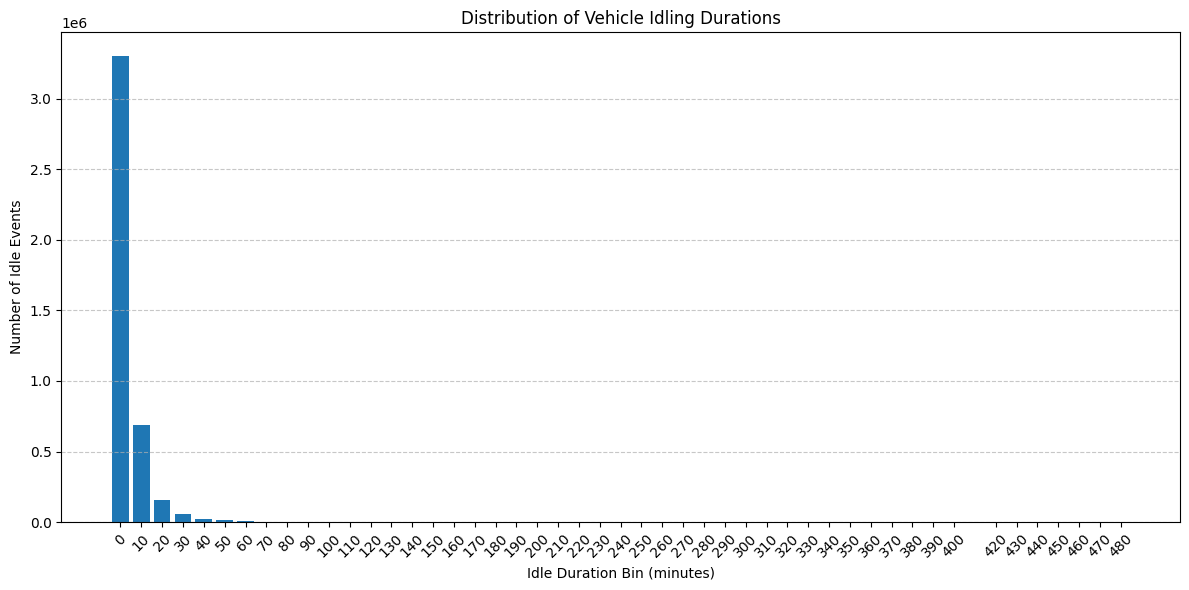

In [0]:
# How long are vehicles idling for? 
 # Summary statistics
cleaned_idle_data.select("minutes_idling").describe().show()

# Histogram binning
idle_distribution = (
    cleaned_idle_data
    .withColumn("idle_bin", (col("minutes_idling") / 10).cast("int") * 10)  # bin by 10-minute intervals
    .groupBy("idle_bin")
    .agg(count("*").alias("event_count"))
    .orderBy("idle_bin")
)

# Convert to Pandas
idle_dist_pd = idle_distribution.toPandas()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(idle_dist_pd['idle_bin'], idle_dist_pd['event_count'], width=8)
plt.xlabel("Idle Duration Bin (minutes)")
plt.ylabel("Number of Idle Events")
plt.title("Distribution of Vehicle Idling Durations")
plt.xticks(idle_dist_pd['idle_bin'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [0]:
# are idle events more frequent during certain shifts or times? 
# Add hour and shift
cleaned_idle_data = cleaned_idle_data.withColumn("hour", hour("start_time"))

# Define shift based on hour
cleaned_idle_data = cleaned_idle_data.withColumn(
    "shift",
    when((col("hour") >= 6) & (col("hour") < 14), "Morning")
    .when((col("hour") >= 14) & (col("hour") < 22), "Afternoon")
    .otherwise("Night")
)

# Count idle events per shift
idle_by_shift = cleaned_idle_data.groupBy("shift").agg(
    count("*").alias("num_idle_events"),
    avg("minutes_idling").alias("avg_idle_minutes")
).orderBy("shift")

idle_by_shift.show()


+---------+---------------+-----------------+
|    shift|num_idle_events| avg_idle_minutes|
+---------+---------------+-----------------+
|Afternoon|        2836852|7.859626650714651|
|  Morning|        1306175|9.032860208879669|
|    Night|         121607|8.016449162740097|
+---------+---------------+-----------------+



In [0]:
idle_by_vehicle = cleaned_idle_data.groupBy("vehicle_id").agg(
    count("*").alias("idle_event_count"),
    avg("minutes_idling").alias("avg_idle_duration"),
    sum("minutes_idling").alias("total_idle_minutes")
).orderBy(col("total_idle_minutes").desc())

idle_by_vehicle.show()


+----------+----------------+------------------+------------------+
|vehicle_id|idle_event_count| avg_idle_duration|total_idle_minutes|
+----------+----------------+------------------+------------------+
|   1086402|           17089| 10.49736282598943|179389.43333333338|
|   1165824|           19655| 8.548281183753065| 168016.4666666665|
|   1033098|           15493|10.054552593644443|155775.18333333335|
|   1063557|           15436|10.011164377645335|154532.33333333337|
|   1142526|           21611| 6.847437261888231|147979.96666666656|
|   1172968|           16340| 8.884063647490812|145165.59999999986|
|   1123142|            9501|14.912628495246121| 141684.8833333334|
|   1033102|           14109| 9.987589481890998|140914.90000000008|
|   1032411|           16542| 8.489608269858545|140435.10000000006|
|   1146884|           16123| 8.624902313465233|139059.29999999996|
|   1175161|           13020| 10.46120967741935|136204.94999999992|
|   1311984|           12505|10.862897507663599|

In [0]:
# are certain drivers idling more than others?
idle_by_driver = cleaned_idle_data.groupBy("driver_id").agg(
    count("*").alias("idle_event_count"),
    avg("minutes_idling").alias("avg_idle_duration")
).orderBy(col("avg_idle_duration").desc())

idle_by_driver.show()


+---------+----------------+------------------+
|driver_id|idle_event_count| avg_idle_duration|
+---------+----------------+------------------+
|4700478.0|            2474|40.954035300458074|
|5311841.0|              14| 34.56428571428572|
|3846507.0|               8| 34.34583333333333|
|5406300.0|              78| 33.07286324786324|
|3868334.0|               3|26.566666666666666|
|5274740.0|             434|26.010637480798774|
|5375675.0|             167|25.963473053892212|
|5361521.0|             126| 24.63783068783068|
|5274770.0|             287|24.108420441347263|
|5274749.0|             606| 23.46083608360834|
|4209177.0|              39|22.942307692307697|
|5274745.0|             449| 22.84049740163327|
|5070689.0|             279|22.724014336917552|
|4228686.0|              11|22.684848484848484|
|5344077.0|             295|22.684519774011314|
|5274752.0|             543|22.577440147329657|
|5348746.0|              16|22.465625000000003|
|4699186.0|              10|22.156666666


**EDA Observation:**

- The median idle duration is typically around 10 minutes, though there are extreme outliers reaching up to 485 minutes. These outliers likely stem from errors during Motive's software setup, where inaccurate tracking led to inflated idle times.
- Idle time remains consistent regardless of the shift (morning, afternoon, or night), suggesting that time of day doesn’t influence idling behavior.
- On a per-vehicle basis, even the vehicles with the highest average idle durations fall within the 10–14 minute range. This shows that idling tends to be relatively stable across vehicles.
- That consistency doesn’t hold at the driver level. The top 10 drivers with the highest average idle durations range from 20 to 40 minutes—likely driven by those same extreme outliers.


##### Features generation from Idle Events
This aggregation summarizes idle behavior per driver per day. It helps quantify how often and how long a truck is idling — key indicators of driver efficiency, fuel usage, and potential safety concerns

First we need to calculate: 
  - The count of idle events per day (remember this need to be combined with the driving data; because of that we need to count the number of idle events)
  - Average idle duration per idle event 
  - Sum of idle minutes per driver id, vehicle id and date

In [0]:
# Group by driver_id, and idle_date
daily_idle_summary = cleaned_idle_data.groupBy("driver_id", "idle_date").agg(
    count("event_id").alias("idle_event_count_per_trip"),
    avg("minutes_idling").alias("avg_idle_duration_per_trip"),
    sum("minutes_idling").alias("total_idle_minutes_per_trip")
).orderBy( "driver_id", "idle_date").cache()

# Show the result
daily_idle_summary.show() 


+---------+----------+-------------------------+--------------------------+---------------------------+
|driver_id| idle_date|idle_event_count_per_trip|avg_idle_duration_per_trip|total_idle_minutes_per_trip|
+---------+----------+-------------------------+--------------------------+---------------------------+
|  67876.0|2023-01-05|                       22|         8.729545454545455|                     192.05|
|  67876.0|2023-01-06|                       28|          9.63630952380952|          269.8166666666666|
|  67876.0|2023-01-07|                        5|         5.276666666666666|         26.383333333333333|
|  67876.0|2023-01-09|                       17|         7.545098039215685|         128.26666666666665|
|  67876.0|2023-01-10|                       17|         8.965686274509803|         152.41666666666666|
|  67876.0|2023-01-11|                        9|         8.527777777777779|                      76.75|
|  67876.0|2023-01-12|                       21|         13.9714

#### `driver_age_years` 
#### EDA
EDA questions that I would like to ask are
- from today date, what are the driver age range at FusionSite? 
- How long have they had been in the company

In [0]:

driver_info = spark.read.csv('dbfs:/FileStore/tables/driver_age_years.csv', inferSchema=True, header=True)
# driver age range
driver_info = driver_info.withColumn("age", floor(datediff(current_date(), col("date_of_birth")) / 365))
driver_info = driver_info.withColumn("tenure_years", floor(datediff(current_date(), col("original_hire_date")) / 365))

driver_pd = driver_info.select("age", "tenure_years").dropna().toPandas()
plt.figure(figsize=(14, 5))

# Age distribution
plt.subplot(1, 2, 1)
sns.histplot(driver_pd["age"], bins=10, kde=True, color="skyblue")
plt.title("Driver Age Distribution at FusionSite")
plt.xlabel("Age")
plt.ylabel("Number of Drivers")

# Tenure distribution
plt.subplot(1, 2, 2)
sns.histplot(driver_pd["tenure_years"], bins=10, kde=True, color="salmon")
plt.title("Driver Tenure at FusionSite")
plt.xlabel("Years at Company")
plt.ylabel("Number of Drivers")

plt.tight_layout()
plt.show()

**EDA Observations:**
- Most drivers fall between the ages of 30 and 50, with a peak around 35–40. 
- The distribution is slightly right-skewed, meaning there are more younger drivers (<25) than older ones (>60), which suggests FusionSite tends to attract mid-career professionals.
- The majority of drivers have been with the company for less than 2 years, which aligns with FusionSite's wave of acquisitions that started in early 2023—possibly leading to both re-hiring and staff turnover.
- There's a steep drop after the first year, and only a small group of drivers have more than 5 years of tenure. This supports the idea that either driver roles are relatively short-term or that the company's structure has been evolving rapidly.


# Features Transformation with Data Aggregation

For each type of data, I first generate the features that from each of the data. Then I joined those features together in 1 feature dataframe.  The features from `driving_trips_agg` provide a detailed history of driver behavior and trip characteristics, which are strong indicators of driving risk and accident likelihood. Features from `all_trips_df_combined` reflect behavioral risk and event history, which are direct precursors or correlates of accident events. Features from `all_trips_df_inspections` provide vehicle-level context and maintenance history, which can affect the probability of mechanical failure or accidents. Features from `all_trips_df_idle` collect idle behavior can reflect inefficient driving patterns, potential distraction, or non-compliance with protocols—all of which may elevate risk.

#### `Idle Data`
This will capture idle events for each driver 

In [0]:
# From data_driving_periods; get distinct driver id, vehicle id, and date

all_trips_df =  cleaned_driving_period.select("driver_id", "trip_date").distinct()
all_trips_df.show()


+---------+----------+
|driver_id| trip_date|
+---------+----------+
|3862130.0|2023-07-19|
|4024350.0|2023-07-18|
|3862219.0|2023-07-18|
|3786829.0|2023-07-19|
|3933445.0|2023-07-19|
|3797887.0|2023-07-19|
|3926457.0|2023-07-19|
|4183324.0|2023-07-18|
|3799191.0|2023-07-18|
|3601229.0|2023-07-18|
|4036812.0|2023-07-18|
|3955522.0|2023-07-19|
|4084862.0|2023-07-19|
|3955561.0|2023-07-19|
|3848278.0|2023-07-20|
|3906271.0|2023-07-18|
|3796799.0|2023-07-18|
|3773505.0|2023-07-18|
|4207825.0|2023-07-18|
|3955652.0|2023-07-20|
+---------+----------+
only showing top 20 rows



In [0]:
# join with idle events
daily_idle_summary_renamed = daily_idle_summary.withColumnRenamed("idle_date", "trip_date")

all_trips_df_idle =all_trips_df.join(daily_idle_summary_renamed,on=["driver_id", "trip_date"],how="left").fillna(0)

driver_window_rows = (
    Window
    .partitionBy("driver_id")
    .orderBy("trip_date")
    .rowsBetween(-7, -1)  # Exclude the current rows 
)

all_trips_df_idle = (
    all_trips_df_idle
    # Rolling average of idle_event_count_per_trip
    .withColumn(
        "rolling_7trip_idle_count",
        avg("idle_event_count_per_trip").over(driver_window_rows)
    )
    # Rolling average of avg_idle_duration_per_trip
    .withColumn(
        "rolling_7trip_avg_idle_duration", # average of average durations
        avg("avg_idle_duration_per_trip").over(driver_window_rows)
    )
    # Rolling average of total_idle_minutes_per_trip
    .withColumn(
        "rolling_7trip_avg_idle_minutes", 
        avg("total_idle_minutes_per_trip").over(driver_window_rows)
    )
    # Finally, sort for display
    .sort("driver_id", col("trip_date").asc()).cache()
)

In [0]:
# check to see if join correctly 
print(all_trips_df.count())
print(all_trips_df_idle.count())
print(all_trips_df.select("driver_id", "trip_date").distinct().count())
print(all_trips_df_idle.select("driver_id", "trip_date").distinct().count())

201834
201834
201834
201834


#### `Inspection Data`
This tell us about the current and historical status of the car


In [0]:
# create has_issues columns:
all_trips_df_vehicle =  cleaned_driving_period.groupby("vehicle_id", "trip_date").agg(
    sum("driving_distance").alias("vehicle_sum_travel_distance"),
    sum("minutes_driving").alias("vehicle_sum_minutes_driving"), 
    count("*").alias("vehicle_num_driving_events")
)
# get minimum trip date for each vehicle 
min_vehicle_trip = cleaned_driving_period.groupby("vehicle_id").agg(min("trip_date").alias("min_trip_date"))
# create a sum travel distance column and sum driving minutes
all_trips_df_vehicle = all_trips_df_vehicle.join(min_vehicle_trip, on="vehicle_id", how="left")

In [0]:
all_trips_df_inspections = (
    all_trips_df_vehicle.alias("t")
    .join(
        inspections_summary.alias("i"),
        (col("t.vehicle_id") == col("i.vehicle_id")) & (col("t.trip_date") == col("i.inspection_date")),
        how="left"
    )
    .select(
        # Columns from the "t" (trip) side
        col("t.vehicle_id").alias("vehicle_id"),
        col("t.trip_date").alias("trip_date"),
        col("t.vehicle_sum_travel_distance").alias("vehicle_sum_travel_distance"),
        col("t.vehicle_sum_minutes_driving").alias("vehicle_sum_minutes_driving"),
        col("t.vehicle_num_driving_events").alias("vehicle_num_driving_events"),
        col("t.min_trip_date").alias("min_trip_date"),
        # Columns from the "i" (inspection) side
        col("i.inspection_date").alias("inspection_date"),
        col("i.num_inspections_per_trip"),
        col("i.num_issues_per_trip")
    )
)
all_trips_df_inspections = all_trips_df_inspections.na.fill({"num_inspections_per_trip": 0, "num_issues_per_trip":0})
# create has_issues columns:
all_trips_df_inspections = all_trips_df_inspections.withColumn(
    "has_issues",
    when(col("num_issues_per_trip").isNull(), None)         
    .when(col("num_issues_per_trip") > 0, lit(1))          
    .otherwise(lit(0))                                      
)

# 1) Define a window partitioned by vehicle_id, ordered by trip_date ascending
w = (
    Window
    .partitionBy("vehicle_id")
    .orderBy("trip_date")
    .rowsBetween(Window.unboundedPreceding, -1)  # from first row up to current
)

# 2) "Carry forward" the last non-null inspection_date
all_trips_df_inspections = all_trips_df_inspections.withColumn(
    "last_inspection_date",
    last(col("inspection_date"), ignorenulls=True).over(w)
).withColumn("last_has_issues",last(col("has_issues"), ignorenulls=True).over(w)).sort(col("vehicle_id").asc(), col("trip_date").asc())
# cummulative window per vehicle order by trip_date
cumulative_window = (
    Window
    .partitionBy("vehicle_id")
    .orderBy("trip_date")
    .rowsBetween(Window.unboundedPreceding, 0)
)

# Add cumulative totals and inspection rate
all_trips_df_inspections = (
    all_trips_df_inspections
    .withColumn("vehicle_cum_distance", sum("vehicle_sum_travel_distance").over(cumulative_window))
    .withColumn("vehicle_cum_inspections", sum("num_inspections_per_trip").over(cumulative_window))
    .withColumn("vehicle_inspection_rate", col("vehicle_cum_inspections") / col("vehicle_cum_distance"))
    .withColumn("vehicle_cum_issues", sum("num_issues_per_trip").over(cumulative_window))
    .withColumn("vehicle_issues_rate", col("vehicle_cum_issues") / col("vehicle_cum_distance"))
    .cache()
)

all_trips_df_inspections.show()

+----------+----------+---------------------------+---------------------------+--------------------------+-------------+---------------+------------------------+-------------------+----------+--------------------+---------------+--------------------+-----------------------+-----------------------+------------------+-------------------+
|vehicle_id| trip_date|vehicle_sum_travel_distance|vehicle_sum_minutes_driving|vehicle_num_driving_events|min_trip_date|inspection_date|num_inspections_per_trip|num_issues_per_trip|has_issues|last_inspection_date|last_has_issues|vehicle_cum_distance|vehicle_cum_inspections|vehicle_inspection_rate|vehicle_cum_issues|vehicle_issues_rate|
+----------+----------+---------------------------+---------------------------+--------------------------+-------------+---------------+------------------------+-------------------+----------+--------------------+---------------+--------------------+-----------------------+-----------------------+------------------+-------

In [0]:

# Create a window that partitions by vehicle_id, orders by trip_date,
# and includes the 7 rows before the current row, BUT not the current row.
driver_window_rows_7 = (
    Window
    .partitionBy("vehicle_id")
    .orderBy("trip_date")
    .rowsBetween(-7, -1)  # last 7 rows, exclude current row
)
driver_window_15 = (
    Window
    .partitionBy("vehicle_id")
    .orderBy("trip_date")
    .rowsBetween(-15, -1)
)

driver_window_30 = (
    Window
    .partitionBy("vehicle_id")
    .orderBy("trip_date")
    .rowsBetween(-30, -1)
)

df_rolling_rows = (
    all_trips_df_inspections
    # --- Rolling 7-trip sums ---

    .withColumn("vehicle_rolling_7trip_num_inspect", sum("num_inspections_per_trip").over(driver_window_rows_7))
    .withColumn("vehicle_rolling_7trip_num_issues",  sum("num_issues_per_trip").over(driver_window_rows_7))
    .withColumn("vehicle_rolling_7trip_sum_travel_dist", sum("vehicle_sum_travel_distance").over(driver_window_rows_7))
    .withColumn("vehicle_rolling_7trip_sum_minutes_driving", sum("vehicle_sum_minutes_driving").over(driver_window_rows_7))
    .withColumn("vehicle_rolling_7trip_num_driving_events", sum("vehicle_num_driving_events").over(driver_window_rows_7))
    # --- Rolling 15-trip sums ---

    .withColumn("vehicle_rolling_15trip_num_inspect", sum("num_inspections_per_trip").over(driver_window_15))
    .withColumn("vehicle_rolling_15trip_num_issues",  sum("num_issues_per_trip").over(driver_window_15))
    .withColumn("vehicle_rolling_15trip_sum_travel_dist", sum("vehicle_sum_travel_distance").over(driver_window_15))
    .withColumn("vehicle_rolling_15trip_sum_minutes_driving", sum("vehicle_sum_minutes_driving").over(driver_window_15))
    .withColumn("vehicle_rolling_15trip_num_driving_events", sum("vehicle_num_driving_events").over(driver_window_15))

    # --- Rolling 30-trip sums ---
    .withColumn("vehicle_rolling_30trip_num_inspect", sum("num_inspections_per_trip").over(driver_window_30))
    .withColumn("vehicle_rolling_30trip_num_issues",  sum("num_issues_per_trip").over(driver_window_30))
    .withColumn("vehicle_rolling_30trip_sum_travel_dist", sum("vehicle_sum_travel_distance").over(driver_window_30))
    .withColumn("vehicle_rolling_30trip_sum_minutes_driving", sum("vehicle_sum_minutes_driving").over(driver_window_30))
    .withColumn("vehicle_rolling_30trip_num_driving_events", sum("vehicle_num_driving_events").over(driver_window_30))

)

df_final = (
    df_rolling_rows
    
    # --- 7-Trip Ratios ---
    .withColumn(
        "vehicle_rolling_7trip_insp_distance",
        col("vehicle_rolling_7trip_num_inspect") / col("vehicle_rolling_7trip_sum_travel_dist")
    )
    .withColumn(
        "vehicle_rolling_7trip_insp_minutes",
        col("vehicle_rolling_7trip_num_inspect") / col("vehicle_rolling_7trip_sum_minutes_driving")
    )
    .withColumn(
        "vehicle_rolling_7trip_insp_events",
        col("vehicle_rolling_7trip_num_inspect") / col("vehicle_rolling_7trip_num_driving_events")
    )
    .withColumn(
        "vehicle_rolling_7trip_issues_distance",
        col("vehicle_rolling_7trip_num_issues") / col("vehicle_rolling_7trip_sum_travel_dist")
    )
    .withColumn(
        "vehicle_rolling_7trip_issues_minutes",
        col("vehicle_rolling_7trip_num_issues") / col("vehicle_rolling_7trip_sum_minutes_driving")
    )
    .withColumn(
        "vehicle_rolling_7trip_issues_events",
        col("vehicle_rolling_7trip_num_issues") / col("vehicle_rolling_7trip_num_driving_events")
    )

    # --- 15-Trip Ratios ---
    .withColumn(
        "vehicle_rolling_15trip_insp_distance",
        col("vehicle_rolling_15trip_num_inspect") / col("vehicle_rolling_15trip_sum_travel_dist")
    )
    .withColumn(
        "vehicle_rolling_15trip_insp_minutes",
        col("vehicle_rolling_15trip_num_inspect") / col("vehicle_rolling_15trip_sum_minutes_driving")
    )
    .withColumn(
        "vehicle_rolling_15trip_insp_events",
        col("vehicle_rolling_15trip_num_inspect") / col("vehicle_rolling_15trip_num_driving_events")
    )
    .withColumn(
        "vehicle_rolling_15trip_issues_distance",
        col("vehicle_rolling_15trip_num_issues") / col("vehicle_rolling_15trip_sum_travel_dist")
    )
    .withColumn(
        "vehicle_rolling_15trip_issues_minutes",
        col("vehicle_rolling_15trip_num_issues") / col("vehicle_rolling_15trip_sum_minutes_driving")
    )
    .withColumn(
        "vehicle_rolling_15trip_issues_events",
        col("vehicle_rolling_15trip_num_issues") / col("vehicle_rolling_15trip_num_driving_events")
    )

    # --- 30-Trip Ratios ---
    .withColumn(
        "vehicle_rolling_30trip_insp_distance",
        col("vehicle_rolling_30trip_num_inspect") / col("vehicle_rolling_30trip_sum_travel_dist")
    )
    .withColumn(
        "vehicle_rolling_30trip_insp_minutes",
        col("vehicle_rolling_30trip_num_inspect") / col("vehicle_rolling_30trip_sum_minutes_driving")
    )
    .withColumn(
        "vehicle_rolling_30trip_insp_events",
        col("vehicle_rolling_30trip_num_inspect") / col("vehicle_rolling_30trip_num_driving_events")
    )
    .withColumn(
        "vehicle_rolling_30trip_issues_distance",
        col("vehicle_rolling_30trip_num_issues") / col("vehicle_rolling_30trip_sum_travel_dist")
    )
    .withColumn(
        "vehicle_rolling_30trip_issues_minutes",
        col("vehicle_rolling_30trip_num_issues") / col("vehicle_rolling_30trip_sum_minutes_driving")
    )
    .withColumn(
        "vehicle_rolling_30trip_issues_events",
        col("vehicle_rolling_30trip_num_issues") / col("vehicle_rolling_30trip_num_driving_events")
    )
    ## rolling for 7days inspection and issuesgiven owned car time 
    .withColumn("vehicle_rolling_7trip_insp_given_date", col("vehicle_rolling_7trip_num_inspect") /datediff(col("trip_date"), col("min_trip_date")))
    .withColumn("vehicle_rolling_7trip_issues_given_date", col("vehicle_rolling_7trip_num_issues") /datediff(col("trip_date"), col("min_trip_date")))

    ## 15 days
    .withColumn("vehicle_rolling_15trip_insp_given_date", col("vehicle_rolling_15trip_num_inspect") /datediff(col("trip_date"), col("min_trip_date")))
    .withColumn("vehicle_rolling_15trip_issues_given_date", col("vehicle_rolling_15trip_num_issues") /datediff(col("trip_date"), col("min_trip_date")))

    ## 30 days
    .withColumn("vehicle_rolling_30trip_insp_given_date", col("vehicle_rolling_30trip_num_inspect") /datediff(col("trip_date"), col("min_trip_date")))
    .withColumn("vehicle_rolling_30trip_issues_given_date", col("vehicle_rolling_30trip_num_issues") /datediff(col("trip_date"), col("min_trip_date")))
)
    
# Fill all vehicle rolling-related columns with 0
rolling_cols = [col_name for col_name in df_final.columns if col_name.startswith("vehicle_rolling_")]
df_final_filled = df_final.fillna(0, subset=rolling_cols)
# Calculate days between current date and last inspection date
df_final_filled = df_final_filled.withColumn(
    "days_since_last_inspection",
    datediff(col("trip_date"), col("last_inspection_date"))
)
# select only some columns
exclude_cols = ["vehicle_sum_travel_distance","vehicle_sum_minutes_driving","vehicle_num_driving_events","inspection_date","num_inspections_per_trip","num_issues_per_trip", "has_issues"]
selected_cols = [col(c) for c in df_final_filled.columns if c not in exclude_cols]

# Apply selection to create a new DataFrame
all_trips_df_inspections = df_final_filled.select(*selected_cols).cache()



in inspection data, I remove "inspection_date", "has_issues", "vehicle_sum_travel_distance", "vehicle_sum_minutes_driving", "vehicle_num_driving_events",num_inspections_per_trip, num_issues_per_trip since those columns contain the "current" data. We only want our data to be "past" data points

In [0]:
# check to see if join correctly 
print(all_trips_df_inspections.count())
print(cleaned_driving_period.select("vehicle_id", "trip_date").distinct().count())
print(all_trips_df_inspections.select("vehicle_id", "trip_date").distinct().count())

208722
208722
208722


#### ` Data Combined Events` 
This will tell us about the driver driving patterns, especially in terms of commiting hazard event 

In [0]:
###
all_trips_df_combined =  cleaned_driving_period.groupby("driver_id", "trip_date").agg(
    sum("driving_distance").alias("driver_sum_travel_distance"),
    sum("minutes_driving").alias("driver_sum_minutes_driving"), 
    count("*").alias("driver_num_driving_events"))

# calculate previous trips 
window_spec= Window.partitionBy("driver_id").orderBy("trip_date")
all_trips_df_combined = all_trips_df_combined \
    .withColumn("prev_sum_travel_distance", lag("driver_sum_travel_distance", 1).over(window_spec)) \
    .withColumn("prev_sum_minutes_driving", lag("driver_sum_minutes_driving", 1).over(window_spec)) \
    .withColumn("prev_num_driving_events", lag("driver_num_driving_events", 1).over(window_spec))

# get minimum trip date for each vehicle 
min_driver_trip = cleaned_driving_period.groupby("driver_id").agg(min("trip_date").alias("min_trip_date"))
# create a sum travel distance column and sum driving minutes
all_trips_df_combined = all_trips_df_combined.join(min_driver_trip, on="driver_id", how="left")

# get the date diff between min travel date and current trip date
all_trips_df_combined = all_trips_df_combined.withColumn("years_since_min_trip_date", (datediff(col("trip_date"), col("min_trip_date")))/365)

# remove min_trip_date
all_trips_df_combined = all_trips_df_combined.drop("min_trip_date")

# create trip_ts column
all_trips_df_combined = all_trips_df_combined.withColumn("trip_ts", to_timestamp(col("trip_date"), "yyyy-MM-dd"))
event_cols = ["driver_sum_travel_distance", "driver_sum_minutes_driving", "driver_num_driving_events"]

rolling_window_days_7 = Window.partitionBy("driver_id") \
    .orderBy(unix_timestamp("trip_ts")) \
    .rangeBetween(-7 * 86400, -1)

rolling_window_days_15 = Window.partitionBy("driver_id") \
    .orderBy(unix_timestamp("trip_ts")) \
    .rangeBetween(-15 * 86400, -1)

rolling_window_days_30 = Window.partitionBy("driver_id") \
    .orderBy(unix_timestamp("trip_ts")) \
    .rangeBetween(-30 * 86400, -1)
# create rolling window for travel distance, minutes driving and driving events 
for col_name in event_cols:
    all_trips_df_combined = all_trips_df_combined.withColumn(f"{col_name}_roll7d", sum(col(col_name)).over(rolling_window_days_7))
    all_trips_df_combined = all_trips_df_combined.withColumn(f"{col_name}_roll15d", sum(col(col_name)).over(rolling_window_days_15))
    all_trips_df_combined = all_trips_df_combined.withColumn(f"{col_name}_roll30d", sum(col(col_name)).over(rolling_window_days_30))


# join all_trips_df_combined with events_summary
all_trips_df_combined = all_trips_df_combined.join(events_summary, ["driver_id", "trip_date"], "left").fillna(0)


all_trips_df_combined.toPandas().head()

,driver_id,trip_date,driver_sum_travel_distance,driver_sum_minutes_driving,driver_num_driving_events,prev_sum_travel_distance,prev_sum_minutes_driving,prev_num_driving_events,years_since_min_trip_date,trip_ts,driver_sum_travel_distance_roll7d,driver_sum_travel_distance_roll15d,driver_sum_travel_distance_roll30d,driver_sum_minutes_driving_roll7d,driver_sum_minutes_driving_roll15d,driver_sum_minutes_driving_roll30d,driver_num_driving_events_roll7d,driver_num_driving_events_roll15d,driver_num_driving_events_roll30d,camera_obstruction,cell_phone,crash,distraction,driver_facing_cam_obstruction,drowsiness,forward_collision_warning,manual_event,near_miss,ran_a_red_light,road_facing_cam_obstruction,seat_belt_violation,speeding,stop_sign_violation,tailgating,unsafe_lane_change,total_events_per_trip,camera_obstruction_roll7d,camera_obstruction_roll15d,camera_obstruction_roll30d,cell_phone_roll7d,...,ran_a_red_light_roll7d,ran_a_red_light_roll15d,ran_a_red_light_roll30d,road_facing_cam_obstruction_roll7d,road_facing_cam_obstruction_roll15d,road_facing_cam_obstruction_roll30d,seat_belt_violation_roll7d,seat_belt_violation_roll15d,seat_belt_violation_roll30d,speeding_roll7d,speeding_roll15d,speeding_roll30d,stop_sign_violation_roll7d,stop_sign_violation_roll15d,stop_sign_violation_roll30d,tailgating_roll7d,tailgating_roll15d,tailgating_roll30d,unsafe_lane_change_roll7d,unsafe_lane_change_roll15d,unsafe_lane_change_roll30d,total_events_per_trip_roll7d,total_events_per_trip_roll15d,total_events_per_trip_roll30d,trip_ts_roll7d,trip_ts_roll15d,trip_ts_roll30d,prev_pending_review_count,low,mid,high,low_roll7d,low_roll15d,low_roll30d,mid_roll7d,mid_roll15d,mid_roll30d,high_roll7d,high_roll15d,high_roll30d
0,67876.0,2023-07-11,274.6,401.133333,8,294.5,330.583333,5,0.512329,2023-07-11,472.6,652.1,1801.1,588.000000,792.583333,2564.416667,17,25,91,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0,1,11,0,0,0,0,0,2,0,0,0,0,1,16,0,1688342400,15184713600,0,0,1,0,0,0,0,0,1,11,0,0,0
1,3601232.0,2024-04-16,109.0,436.250000,21,136.0,515.683333,22,1.290411,2024-04-16,445.0,1102.7,1939.5,1510.100000,3533.816667,5969.333333,93,187,337,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,2,0,2,4,0,1,1,0,0,0,0,0,0,0,4,8,0,3424464000,8557488000,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3601235.0,2023-01-24,96.3,312.616667,24,162.3,467.700000,18,0.057534,2023-01-24,457.6,1072.7,1456.0,1627.516667,3607.883333,4965.166667,82,189,244,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,3,0,...,0,0,0,0,0,0,0,0,1,4,15,19,0,1,1,0,0,0,0,0,0,4,18,27,5022518400,13389840000,18408297600,0,1,0,0,1,3,3,3,12,16,0,0,0
3,3602916.0,2023-03-13,37.4,62.816667,1,0.0,0.000000,0,0.000000,2023-03-13,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3606675.0,2023-04-02,86.5,133.933333,2,91.2,380.016667,32,0.243836,2023-04-02,411.5,684.9,1502.2,1687.566667,3005.983333,5938.566667,177,283,523,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5,10,19,13,15,20,0,0,0,0,0,0,18,26,41,8400240000,15118012800,30223152000,0,0,2,0,0,1,4,5,9,15,0,0,0


In [0]:
roll_days = [7, 15, 30]
event_ratio_cols = [col for col in all_trips_df_combined.columns if any(col.endswith(f"_roll{d}d") for d in roll_days)]
for col_name in event_ratio_cols:
    all_trips_df_combined = all_trips_df_combined.withColumn(f"ratio_{col_name}_per_year", expr(f"CASE WHEN years_since_min_trip_date > 0 THEN {col_name} / years_since_min_trip_date ELSE 0 END"))

for col_name in event_ratio_cols:
    for d in roll_days:
        suffix = f"_roll{d}"
        if col_name.endswith(suffix):
            base_name = col_name.replace(suffix, "")
            
            # Match to rolling driver metrics
            dist_col = f"driver_sum_travel_distance_roll{d}d"
            min_col = f"driver_sum_minutes_driving_roll{d}d"
            evnt_col = f"driver_num_driving_events_roll{d}d"

            # Build ratio columns with CASE WHEN to avoid division by zero
            all_trips_df_combined = all_trips_df_combined \
                .withColumn(f"ratio_{base_name}_per_mile_roll{d}d", expr(
                    f"CASE WHEN {dist_col} > 0 THEN {col_name} / {dist_col} ELSE 0 END"
                )) \
                .withColumn(f"ratio_{base_name}_per_minute_roll{d}d", expr(
                    f"CASE WHEN {min_col} > 0 THEN {col_name} / {min_col} ELSE 0 END"
                )) \
                .withColumn(f"ratio_{base_name}_per_event_roll{d}d", expr(
                    f"CASE WHEN {evnt_col} > 0 THEN {col_name} / {evnt_col} ELSE 0 END"
                ))

all_trips_df_combined = all_trips_df_combined.drop("trip_ts","driver_sum_travel_distance","driver_sum_minutes_driving","driver_num_driving_events" ).cache()

# calculate rate of pending reviews of the previous trips traveling stat (like driving distance, minutes, event count)
all_trips_df_combined = all_trips_df_combined.withColumn(
    "prev_review_rate_per_km", round(col("prev_pending_review_count") / col("prev_sum_travel_distance"), 4)
).withColumn(
    "prev_review_rate_per_min", round(col("prev_pending_review_count") / col("prev_sum_minutes_driving"), 4)
).withColumn(
    "prev_review_rate_per_event", round(col("prev_pending_review_count") / col("prev_num_driving_events"), 4)
)
all_trips_df_combined.toPandas().head()

,driver_id,trip_date,prev_sum_travel_distance,prev_sum_minutes_driving,prev_num_driving_events,years_since_min_trip_date,driver_sum_travel_distance_roll7d,driver_sum_travel_distance_roll15d,driver_sum_travel_distance_roll30d,driver_sum_minutes_driving_roll7d,driver_sum_minutes_driving_roll15d,driver_sum_minutes_driving_roll30d,driver_num_driving_events_roll7d,driver_num_driving_events_roll15d,driver_num_driving_events_roll30d,camera_obstruction,cell_phone,crash,distraction,driver_facing_cam_obstruction,drowsiness,forward_collision_warning,manual_event,near_miss,ran_a_red_light,road_facing_cam_obstruction,seat_belt_violation,speeding,stop_sign_violation,tailgating,unsafe_lane_change,total_events_per_trip,camera_obstruction_roll7d,camera_obstruction_roll15d,camera_obstruction_roll30d,cell_phone_roll7d,cell_phone_roll15d,cell_phone_roll30d,crash_roll7d,crash_roll15d,...,ratio_near_miss_roll30d_per_year,ratio_ran_a_red_light_roll7d_per_year,ratio_ran_a_red_light_roll15d_per_year,ratio_ran_a_red_light_roll30d_per_year,ratio_road_facing_cam_obstruction_roll7d_per_year,ratio_road_facing_cam_obstruction_roll15d_per_year,ratio_road_facing_cam_obstruction_roll30d_per_year,ratio_seat_belt_violation_roll7d_per_year,ratio_seat_belt_violation_roll15d_per_year,ratio_seat_belt_violation_roll30d_per_year,ratio_speeding_roll7d_per_year,ratio_speeding_roll15d_per_year,ratio_speeding_roll30d_per_year,ratio_stop_sign_violation_roll7d_per_year,ratio_stop_sign_violation_roll15d_per_year,ratio_stop_sign_violation_roll30d_per_year,ratio_tailgating_roll7d_per_year,ratio_tailgating_roll15d_per_year,ratio_tailgating_roll30d_per_year,ratio_unsafe_lane_change_roll7d_per_year,ratio_unsafe_lane_change_roll15d_per_year,ratio_unsafe_lane_change_roll30d_per_year,ratio_total_events_per_trip_roll7d_per_year,ratio_total_events_per_trip_roll15d_per_year,ratio_total_events_per_trip_roll30d_per_year,ratio_trip_ts_roll7d_per_year,ratio_trip_ts_roll15d_per_year,ratio_trip_ts_roll30d_per_year,ratio_low_roll7d_per_year,ratio_low_roll15d_per_year,ratio_low_roll30d_per_year,ratio_mid_roll7d_per_year,ratio_mid_roll15d_per_year,ratio_mid_roll30d_per_year,ratio_high_roll7d_per_year,ratio_high_roll15d_per_year,ratio_high_roll30d_per_year,prev_review_rate_per_km,prev_review_rate_per_min,prev_review_rate_per_event
0,3848275.0,2024-12-11,98.5,357.150000,24,1.846575,631.2,1404.3,2688.7,1896.066667,4058.750000,7928.350000,104,224,440,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.083086,1.624629,1.624629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.747774,17.329377,18.412463,4.693858e+09,7.509405e+09,9.384767e+09,1.083086,1.083086,1.083086,0.000000,0.541543,0.541543,0.0,0.0,0.0,0.0,0.0,0.0
1,3886528.0,2023-02-24,163.6,333.050000,13,0.030137,681.8,1190.3,1190.3,1644.733333,2790.116667,2790.116667,70,123,123,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,0,0,0,0,2,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.363636,199.090909,199.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.363636,265.454545,265.454545,1.112762e+11,2.781533e+11,2.781533e+11,0.000000,0.000000,0.000000,66.363636,199.090909,199.090909,0.0,0.0,0.0,0.0,0.0,0.0
2,3886528.0,2024-06-11,131.6,295.800000,16,1.326027,588.7,1192.9,2566.0,1355.783333,2846.483333,6044.100000,68,131,269,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,3886528.0,2024-06-25,149.2,348.983333,15,1.364384,619.7,1337.4,2398.7,1451.083333,3210.300000,5760.983333,71,162,277,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# check to see if join correctly 
print(all_trips_df_combined.count())
print(all_trips_df_combined.select("driver_id", "trip_date").distinct().count())
print(all_trips_df_combined.select("driver_id", "trip_date").distinct().count())
print(all_trips_df_combined.filter(col("driver_id")==4967877).count())

201834
201834
201834
111


### Create with Driver Age and Experience 

From UKG, we then grabbed driver age and experience. Unfortunately, we don't have the driver historical driving experience before joining the company. We would use the driver starting date as our driving experience within the organization

In [0]:
driver_info = spark.read.csv('dbfs:/FileStore/tables/driver_age_years.csv', inferSchema=True, header=True)
driver_info= driver_info.drop("employee_id")
# cast driver_company_id to double 
driver_info = driver_info.withColumn("driver_company_id", col("driver_company_id").cast("double"))
# join with driving period 
all_trips_df =  cleaned_driving_period.select("driver_company_id", "driver_id", "trip_date").distinct()
print("data driving periods cnt", all_trips_df.count())
driver_info_w_trips = all_trips_df.join(driver_info, ["driver_company_id"], "left")
# convert to datetype
driver_info_w_trips = driver_info_w_trips.withColumn("trip_date", to_date("trip_date")) \
    .withColumn("date_of_birth", to_date("date_of_birth")) \
    .withColumn("original_hire_date", to_date("original_hire_date")) \
    .withColumn("date_of_termination", to_date("date_of_termination"))

# calculate driver age at trip date
driver_info_w_trips = driver_info_w_trips.withColumn(
    "age_at_trip",
    (datediff(col("trip_date"), col("date_of_birth")) / 365).cast("int")
)

# calculate driver working date at trip date
driver_info_w_trips = driver_info_w_trips.withColumn(
    "working_end_date",
    when(col("date_of_termination").isNotNull(), 
         when(col("trip_date") <= col("date_of_termination"), col("trip_date"))
         .otherwise(col("date_of_termination"))
    ).otherwise(col("trip_date"))
)
driver_info_w_trips = driver_info_w_trips.withColumn("working_days_at_trip",datediff(col("working_end_date"), col("original_hire_date")).cast("int")).withColumn("working_years_at_trip", col("working_days_at_trip") / 365)
# Handle edge cases: if original_hire_date is after trip → set to 0
driver_info_w_trips = driver_info_w_trips.withColumn("working_days_at_trip", when(col("working_days_at_trip") < 0, 0).otherwise(col("working_days_at_trip")))
# remove duplicates 
driver_info_w_trips=driver_info_w_trips.dropDuplicates()
driver_info_w_trips = driver_info_w_trips.drop("age_in_years","working_end_date", "date_of_birth", "date_of_termination", "original_hire_date", "driver_company_id","years_in_company").cache()
driver_info_w_trips.show()

#### Join the aggregate driver information above with zipcode
This is used to map the vehicle with corresponding sites's zipcode. Later on, we can have this zipcode to map with weather information and car crashes details 


In [0]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

# Define the schema (using StringType for motive_group_id to handle list-like values)
schema = StructType([
    StructField("brand", StringType(), True),
    StructField("city", StringType(), True),
    StructField("zipcode", IntegerType(), True),
    StructField("motive_group_id", StringType(), True)
])

# List of data tuples (note: empty motive_group_id is represented as None)
fusion_site_data = [
    ("Arkansas Portable Toilets", "North Little Rock", 72114, "55542"),
    ("Arkansas Portable Toilets", "Fayetteville", 72701, "55543"),
    ("Gotta Go Site Service Rentals", "Jackson", 39209, "119580"),
    ("American Johnny", "Saltillo", 38866, "151195"),
    ("Safety-Quip Portable Toilets", "Memphis", 38118, "63332"),
    ("Stamback Services", "Tucson", 85756, "162377"),
    ("Stamback Services", "Willcox", 85643, "161452"),
    ("Stamback Services", "Willcox", 85643, "162372"),
    ("A Clean Portoco", "Harlingen", 78550, "119083"),
    ("Forza Site Services", "Lubbock", 79423, "119588"),
    ("Forza Site Services", "Lubbock", 79423, "117030"),
    ("Forza Site Services", "Kermit", 79745, "117031"),
    ("Forza Site Services", "Pecos", 79772, "146102"),
    ("J Bar", "Burnet", 78611, "150933"),
    ("Portable Services", "Augusta", 30901, "53751"),
    ("Griffin Waste", "Asheville", 28806, "53753"),
    ("Griffin Waste", "Asheville", 28806, "68660"),
    ("A Sani-Can", "Denver", 28037, "55550"),
    ("A Sani-Can", "Greensboro", 27405, "55551"),
    ("A Sani-Can", "Salisbury", 28147, "55552"),
    ("LittleJohn Portable Toilets", "Greenville", 29604, "137745"),
    ("Portable Services", "Columbia", 29203, "54012"),
    ("East Tennessee Portables", "Knoxville", 37924, "55431"),
    ("MC Septic", "Greeneville", 37743, "60569"),
    ("R & R Septic & Porta - Toilets", "Dayton", 24382, "130474"),
    ("JW Craft Portable Restrooms", "Naples", 34104, "110782"),
    ("Premier Portables/ Prestigious Restrooms", "Fort Myers", 33905, "60498"),
    ("Porta Serve", "Newberry", 32669, "134638"),
    ("Georgia Container Inc./ Portable Toilets of Georgia", "Carrollton", 30117, "102953"),
    ("Fusionsite Services", "Nashville", 37210, "55428"),
    ("Fusionsite Services", "Nashville", 37210, "55429"),
    ("Fusionsite Services", "Nashville", 37210, "123038"),
    ("Maxwell Septic", "Gallatin", 37066, "155533"),
    ("The Bolles Company", "Chattanooga", 37421, "123039"),
    ("FusionSite - Cedar Rapids", "Cedar Rapids", 52404, "138855"),
    ("Blue Moon Restrooms", "Nicholasville", 40356, "100868"),
    ("Bullitt Septic Service", "Shepherdsville", 40165, "54016"),
    ("Moon Companies", "Louisville", 40216, "171121"),
    ("Moon Companies", "Louisville", 40216, "54015"),
    ("Moon Companies", "Louisville", 40216, "54014"),
    ("Moon Companies", "Louisville", 40216, "54013"),
    ("A. John/A1 Portable Toilets", "Walden", 12586, "96457"),
    ("C&L Sanitation; Safe-Way Barricades", "Perrysburg", 43551, "76130"),
    ("Rent-A-John", "Columbus", 43207, "50049"),
    ("Port A Bowl Restroom Co", "Plumsteadville", 18949, "50046"),
    ("Ace Disposal", "Malvern", 19355, "99738"),
    ("Bucky's Restrooms", "Fitchburg", 53575, "110783"),
    ("Stranders Sanitary", "Lodi", 53555, "120444"), 
    ("Stranders Sanitary", "Lodi", 53555, "162868"),
    ("SAN ANGELO- TOPS SEPTIC", "San Angelo", 76905, "117033") # added extra
]
fss_site_mapping = spark.createDataFrame(fusion_site_data, schema)

trips_with_site_info =  cleaned_driving_period.filter(col("group_id").isNotNull()).select("driver_id", "vehicle_id", "trip_date", "group_id", "group_name").distinct()
# concert group_id into int and then string 
trips_with_site_info = trips_with_site_info.withColumn("group_id", col("group_id").cast("int"))
trips_with_site_info = trips_with_site_info.withColumn("motive_group_id", col("group_id").cast("string"))
# join trips_with_site_info with fss_site 
trips_with_site_info = trips_with_site_info.join(
    fss_site_mapping,
    on="motive_group_id",
    how="left"  # use "inner" if you only want matching rows
)

# print case where group_id is null and count 

trips_with_site_info.show()

+---------------+---------+----------+----------+--------+--------------------+--------------------+-----------------+-------+
|motive_group_id|driver_id|vehicle_id| trip_date|group_id|          group_name|               brand|             city|zipcode|
+---------------+---------+----------+----------+--------+--------------------+--------------------+-----------------+-------+
|          53753|3797957.0|   1137816|2023-07-19|   53753|NC - Griffin Wast...|       Griffin Waste|        Asheville|  28806|
|          54013|3988840.0|   1123136|2023-07-18|   54013| KY - moon portables|      Moon Companies|       Louisville|  40216|
|          55542|3955928.0|   1189293|2023-07-18|   55542|    AR - Little Rock|Arkansas Portable...|North Little Rock|  72114|
|          53753|3795663.0|   1136152|2023-07-14|   53753|NC - Griffin Wast...|       Griffin Waste|        Asheville|  28806|
|          50049|3749439.0|   1086397|2023-07-14|   50049|OH - Rent - A - John|         Rent-A-John|         Co

In [0]:
print(trips_with_site_info.count())
print(trips_with_site_info.select("driver_id", "vehicle_id", "trip_date").distinct().count())
print(cleaned_driving_period.filter(col("group_id").isNotNull()).select("driver_id", "vehicle_id", "trip_date").distinct().count())


216942
216942
216942


### Join ALL table together
Here are the tables that I am going to join to create the final features table for machine learning 
- driver_info_w_trips
- all_trips_df_inspections
- all_trips_df_idle
- all_trips_df_combined
- driving_trips_agg
- trips_with_site_info

The final lists of columns would be 

- `driving_trips_agg`: 
    - `driver_total_trip_count`: Total number of unique trip dates recorded for each driver. Used to quantify driver experience.
    - `first_driving_date`: The earliest recorded trip date for each driver. Used to calculate driving tenure.
    - `driver_log_trip_count`: Natural log of `driver_total_trip_count`. Provides a normalized version of total trip count for modeling.
    - `trip_ts`: Timestamp version of `trip_date`. Created to support time-based rolling windows. (Dropped later in pipeline.)
    - `rolling_7day_trip_count`: Number of trips made by a driver in the 7 calendar days before the current trip date (excluding the current trip). Reflects short-term driving frequency.
    - `rolling_30day_trip_count`: Number of trips made by a driver in the 30 calendar days before the current trip date (excluding the current trip). Reflects longer-term driving frequency.
    - `previous_trip_date`: Date of the driver’s previous trip. Used to calculate trip spacing.
    - `days_since_last_trip`: Number of days between the current trip and the previous trip for a given driver. Captures trip recency.
    - `driving_year_since_first_trip`: Number of years since the driver’s first recorded trip. Normalizes behavior by driving tenure.
    - `trip_date_distance`: Total distance (in miles) driven on a given trip date for a driver. Aggregated across all segments.
    - `trip_date_minutes`: Total driving time (in minutes) on a given trip date.
    - `trip_date_count`: Number of trip segments or driving events for the driver on the given trip date.
    - `trip_date_avg_speed_mph`: Average speed (in MPH) for the trip date, calculated as `trip_date_distance / (trip_date_minutes / 60)`. Represents per-trip driving speed.
    - `previous_trip_date_avg_speed_mph`: Lagged value of `trip_date_avg_speed_mph` from the driver’s previous trip. Captures change in speed behavior.
    - `rolling_7trip_avg_speed_mph`: Average of `trip_date_avg_speed_mph` across the last 7 trips (excluding the current trip). Highlights recent speed patterns.
    - `rolling_15trip_avg_speed_mph`: Rolling average speed across the previous 15 trips.
    - `rolling_30trip_avg_speed_mph`: Rolling average speed across the previous 30 trips.
    - `prev_trip_date_distance`: Distance from the previous trip, used to compute change from one trip to the next.
    - `prev_trip_date_minutes`: Driving minutes from the previous trip.
    - `change_in_distance`: Difference in distance between the current and previous trip (`trip_date_distance - prev_trip_date_distance`).
    - `change_in_minutes`: Difference in driving time between the current and previous trip.
    - `rolling_7day_total_distance`: Total distance driven by the driver in the 7 calendar days before the current trip date (excluding the current trip).
    - `rolling_7day_total_minutes`: Total minutes driven in the past 7 days (excluding the current trip).
    - `rolling_15day_total_distance`: Total distance driven by the driver in the past 15 days.
    - `rolling_15day_total_minutes`: Total driving time in minutes over the past 15 days.
    - `rolling_30day_total_distance`: Total distance covered in the past 30 calendar days.
    - `rolling_30day_total_minutes`: Total driving time in minutes in the 30-day period before the current trip.

- `all_trips_df_combined`: 
    - `total_events_per_trip`: Total number of events recorded for a given driver on a specific trip date. This provides a measure of overall activity volume.
    - `<event_type>`: Count of events of a specific type (e.g., `idling`, `harsh_braking`, etc.) for a given driver on a specific trip date. These columns are generated dynamically based on distinct values in the `type` column of the source data.
    - `<event_type>_roll7d`: Rolling 7-day sum of the `<event_type>` for each driver, excluding the current trip date. This captures short-term trends in driver behavior.
    - `<event_type>_roll15d`: Rolling 15-day sum of the `<event_type>` for each driver, excluding the current trip date. This helps identify mid-term behavioral patterns.
    - `<event_type>_roll30d`: Rolling 30-day sum of the `<event_type>` for each driver, excluding the current trip date. Useful for understanding long-term event frequency or escalation.
    - `low`: Count of speeding events during the trip date where `max_over_speed_in_mph` was less than or equal to 10 MPH. Represents low-risk speeding behavior.
    - `mid`: Count of speeding events during a trip date where `max_over_speed_in_mph` was between 11 and 25 MPH. Represents moderate-risk speeding behavior.
    - `high`: Count of speeding events during a trip date where `max_over_speed_in_mph` exceeded 25 MPH. Represents high-risk or severe speeding behavior.
    - `low_roll7d`: Rolling 7-day sum of low-level speeding events for each driver, excluding the current trip date. Indicates recent low-risk speeding frequency.
    - `mid_roll7d`: Rolling 7-day sum of mid-level speeding events for each driver, excluding the current trip date.
    - `high_roll7d`: Rolling 7-day sum of high-level speeding events for each driver, excluding the current trip date.
    - `low_roll15d`: Rolling 15-day sum of low-level speeding events for each driver, excluding the current trip date.
    - `mid_roll15d`: Rolling 15-day sum of mid-level speeding events for each driver, excluding the current trip date.
    - `high_roll15d`: Rolling 15-day sum of high-level speeding events for each driver, excluding the current trip date.
    - `low_roll30d`: Rolling 30-day sum of low-level speeding events for each driver, excluding the current trip date.
    - `mid_roll30d`: Rolling 30-day sum of mid-level speeding events for each driver, excluding the current trip date.
    - `high_roll30d`: Rolling 30-day sum of high-level speeding events for each driver, excluding the current trip date.
    - `prev_pending_review_count`: Number of coaching events with `coaching_status = 'pending_review'` recorded on the **previous trip** for the same driver. Used to assess whether recent coaching needs correlate with other driving behaviors or risks.
    - `prev_sum_travel_distance`: Total driving distance (in miles) from the previous trip for the same driver. Used to track recent driving history.
    - `prev_sum_minutes_driving`: Total driving duration (in minutes) from the previous trip for the same driver.
    - `prev_num_driving_events`: Number of discrete driving periods from the previous trip for the same driver.
    - `years_since_min_trip_date`: Number of years since the driver’s first recorded trip. Calculated as the difference in days between the current trip and the earliest recorded trip for the driver, divided by 365.
    - `<metric>_roll7d`: 7-day rolling sum for the specified metric (e.g., `driver_sum_travel_distance`, `driver_sum_minutes_driving`, `driver_num_driving_events`, or event counts like `speeding`). Excludes the current trip and captures short-term behavioral trends.
    - `<metric>_roll15d`: 15-day rolling sum for the specified metric, excluding the current trip.
    - `<metric>_roll30d`: 30-day rolling sum for the specified metric, excluding the current trip.
    - `ratio_<metric>_rollXd_per_year`: Normalized ratio of a 7/15/30-day rolling metric divided by the number of years since the driver's first recorded trip. Used to contextualize recent behavior over the driver’s active history.
    - `ratio_<metric>_per_mile_rollXd`: Ratio of the rolling event count to the driver’s total miles traveled over the same 7/15/30-day period. Used to understand how frequently the event occurs relative to distance.
    - `ratio_<metric>_per_minute_rollXd`: Ratio of the rolling event count to the driver’s total minutes driving over the same 7/15/30-day period.
    - `ratio_<metric>_per_event_rollXd`: Ratio of the rolling event count to the total number of driving periods over the same 7/15/30-day period.
    - `prev_review_rate_per_km`: Ratio of the number of `pending_review` events from the previous trip to the previous trip’s total miles driven. Used to detect coaching event density.
    - `prev_review_rate_per_min`: Ratio of previous trip's `pending_review` events per minute driven.
    - `prev_review_rate_per_event`: Ratio of previous trip's `pending_review` events per driving event (i.e., per distinct trip segment).

Notes: The event types are

> event_types = ["camera_obstruction", "cell_phone", "crash", "distraction", "driver_facing_cam_obstruction", "drowsiness", "forward_collision_warning", "manual_event", "near_miss", "ran_a_red_light", "road_facing_cam_obstruction", "seat_belt_violation", "speeding", "stop_sign_violation", "tailgating", "unsafe_lane_change"]

- `all_trips_df_inspections`: 
    - `last_inspection_date`: The most recent non-null inspection date for the vehicle, prior to the current trip. Used to calculate time since last inspection.
    - `last_has_issues`: Status (1 or 0) indicating whether the most recent prior inspection had issues. Enables tracking issue resolution or recurrence.
    - `vehicle_cum_distance`: Cumulative sum of miles driven by the vehicle up to and including the current trip. Useful for normalizing inspection frequency over time.
    - `vehicle_cum_inspections`: Cumulative count of inspections for the vehicle up to the current trip.
    - `vehicle_inspection_rate`: Ratio of cumulative inspections to cumulative distance. Helps assess inspection frequency over total mileage.
    - `vehicle_cum_issues`: Cumulative number of issues detected for the vehicle up to the current trip date.
    - `vehicle_issues_rate`: Ratio of cumulative issues to cumulative distance driven. Indicates issue density per mile over the life of the vehicle.
    - `vehicle_rolling_[7|15|30]trip_num_inspect`: Sum of inspections across the previous 7, 15, or 30 trips (excluding current trip). Tracks short-, mid-, and long-term inspection activity.
    - `vehicle_rolling_[7|15|30]trip_num_issues`: Sum of inspection issues (open/resolved) across the previous 7, 15, or 30 trips.
    - `vehicle_rolling_[7|15|30]trip_sum_travel_dist`: Total distance driven in the previous 7, 15, or 30 trips.
    - `vehicle_rolling_[7|15|30]trip_sum_minutes_driving`: Total driving time (in minutes) across the previous 7, 15, or 30 trips.
    - `vehicle_rolling_[7|15|30]trip_num_driving_events`: Total number of driving events over the past 7, 15, or 30 trips.
    - `vehicle_rolling_[7|15|30]trip_insp_distance`: Ratio of inspections to miles driven over the last 7, 15, or 30 trip. Used to normalize inspection frequency.
    - `vehicle_rolling_[7|15|30]trip_insp_minutes`: Ratio of inspections to total minutes driven in the same rolling window.
    - `vehicle_rolling_[7|15|30]trip_insp_events`: Ratio of inspections to driving events over the last 7, 15, or 30 trips.
    - `vehicle_rolling_[7|15|30]trip_issues_distance`: Ratio of inspection issues to miles driven over the last 7, 15, or 30 trips.
    - `vehicle_rolling_[7|15|30]trip_issues_minutes`: Ratio of issues to driving time (minutes) over the respective rolling window.
    - `vehicle_rolling_[7|15|30]trip_issues_events`: Ratio of issues to driving events in the past 7, 15, or 30 trips.
    - `vehicle_rolling_[7|15|30]trip_insp_given_date`: Ratio of inspections in the past N trips to total days since the vehicle’s first recorded trip. Normalizes short- and long-term inspection activity by age of vehicle usage
    - `vehicle_rolling_[7|15|30]trip_issues_given_date`: Ratio of inspection issues in the past N trips to days since the vehicle’s first trip.
    - `days_since_last_inspection`: Number of days since the last recorded inspection for the vehicle. Useful for gap analysis and risk monitoring.

- `all_trips_df_idle`
    - `idle_event_count_per_trip`: Number of idling events recorded for a driver on a given `idle_date`. Represents how frequently a vehicle was left idling that day.
    - `avg_idle_duration_per_trip`: Average duration (in minutes) of idling events for a driver on a given day. Helps quantify the typical length of each idle period.
    - `total_idle_minutes_per_trip`: Total time (in minutes) a driver spent idling across all events on a given day. Useful for identifying excessive idling behavior at the trip/day level.
    - `rolling_7trip_idle_count`: Rolling average count of idle events over the past 7 trips (excluding the current trip) for each driver. Captures recent idling frequency trends.
    - `rolling_7trip_avg_idle_duration`: Rolling average of the average idle duration per trip over the past 7 trips (excluding the current trip). Helps identify consistent short or long idle periods.
    - `rolling_7trip_avg_idle_minutes`: Rolling average of total idle minutes per trip over the past 7 trips (excluding the current trip). Reflects recent cumulative idling behavior.

- `driver_info_w_trips`: 
    - `age_at_trip`: The driver’s age in whole years at the time of the trip, calculated as the difference between `trip_date` and `date_of_birth` divided by 365. Cast as integer for clean downstream use.
    - `working_days_at_trip`: Total number of days the driver has worked for the company as of the `trip_date`. Computed as the difference between `trip_date` (or `date_of_termination`, whichever is earlier) and `original_hire_date`. Values less than 0 are set to 0 to handle edge cases where the trip happened before the driver was hired.
    - `working_years_at_trip`: The driver’s tenure in years at the company at the time of the trip. Calculated by dividing `working_days_at_trip` by 365. This column gives a normalized view of work experience on an annual scale.

- `trips_with_site_info`: 
    - `zipcode` : The ZIP code corresponding to the service provider’s base location, joined from the `fss_site_mapping` table based on `group_id`. Integer type, helps in location-level analytics.
    - `motive_group_id` : Motive Group ID for a specific group regions that links service provider info (`brand`, `city`, `zipcode`) to trip records via `group_id`.


In [0]:
features_data = cleaned_driving_period.select("trip_date", "driver_id", "vehicle_id").distinct()

# join with driver info 
#features_data = features_data.join(driver_info_w_trips, ["driver_id","trip_date"], how = "left")

# join with trips_with_site_info
features_data= features_data.join(trips_with_site_info, ["driver_id", "vehicle_id", "trip_date"], how = "left")

# join with driving_trips_agg
driving_trips_agg= driving_trips_agg.drop("trip_ts")
features_data = features_data.join(driving_trips_agg, ["driver_id", "trip_date"], how = "left")

#  join with all_trips_df_inspections
features_data = features_data.join(all_trips_df_inspections, ["vehicle_id", "trip_date"], how = "left")

# join with all_trips_df_idle
all_trips_df_idle= all_trips_df_idle.drop("driver_company_id")
features_data = features_data.join(all_trips_df_idle, ["driver_id", "trip_date"], how = "left")

# join with all_trips_df_combined
features_data= features_data.join(all_trips_df_combined, ["driver_id", "trip_date"], how = "left")

# check to see if join correctly 
print(features_data.count())
print(cleaned_driving_period.select("driver_id", "vehicle_id", "trip_date").distinct().count())
print(features_data.select("driver_id","vehicle_id", "trip_date").distinct().count())
print(features_data.filter(col("driver_id")==4967877).count())

216942
216942
216942
116


Now, I need to remove the current state of the driver or vehicle status related columns. The reason why is that we are predicting the chance of driver getting into an accident based on the historical information about them. Columns we are removing are  belowed, these columns were used to calculate historical related features or help determine some ratio features
- `brand` , `city` and `motive_group_id `: these columns contains similarly information as column `group_name`
- `trip_date_distance`
- `trip_date_minutes`
- `trip_date_count`
- `trip_date_avg_speed_mph`
- `total_events_per_trip`
- `first_driving_date`
- `previous_trip_date`
- `min_trip_date`
- `last_inspection_date`
- <event_type> (e.g., speeding, crash, etc.)
-low, mid, high (speeding levels on that trip)
- `idle_event_count_per_trip`
- `avg_idle_duration_per_trip`
- `total_idle_minutes_per_trip`

After removing those columns, the final categorical data is `group_name`, which is then processed by transforming with One-Hot-Encoding

In [0]:
# remove current state
# List of specific column names to drop
columns_to_drop = [
    "brand", "city", "motive_group_id",
    "trip_date_distance",
    "trip_date_minutes",
    "trip_date_count",
    "trip_date_avg_speed_mph",
    "previous_trip_date",
    "min_trip_date", 
    "first_driving_date",
    "last_inspection_date", 
    "total_events_per_trip",
    "idle_event_count_per_trip",
    "avg_idle_duration_per_trip",
    "total_idle_minutes_per_trip",
    "low", "mid", "high"  # speeding level categories
]
event_types = [
    "camera_obstruction", "cell_phone", "crash", "distraction",
    "driver_facing_cam_obstruction", "drowsiness", "forward_collision_warning",
    "manual_event", "near_miss", "ran_a_red_light", "road_facing_cam_obstruction",
    "seat_belt_violation", "speeding", "stop_sign_violation", "tailgating", "unsafe_lane_change"
]

columns_to_drop.extend(event_types)

# Drop the columns
features_data = features_data.drop(*columns_to_drop).cache()


# check to see if join correctly 
print(features_data.count())
print(cleaned_driving_period.select("driver_id", "vehicle_id", "trip_date").distinct().count())
print(features_data.select("driver_id","vehicle_id", "trip_date").distinct().count())
print(features_data.filter(col("driver_id")==4967877).count())

216942
216942
216942
116


In [0]:
# one hot encoding for group_name

# Step 1: Get distinct group names
group_names = [row["group_name"] for row in features_data.select("group_name").distinct().collect() if row["group_name"] is not None]

# Step 2: Start from base DataFrame
features_data_transformed = features_data

# Step 3: For each group_name, create a binary column
for name in group_names:
    clean_col_name = name.lower().replace(" ", "_").replace("-", "_").replace(".", "").replace("/", "").replace("&", "_").replace("__", "_")  # Clean for column safety
    features_data_transformed = features_data_transformed.withColumn(
        f"group_{clean_col_name}", when(col("group_name") == name, 1).otherwise(0)
    )

# Optional: Drop original group_name column
features_data_transformed = features_data_transformed.drop("group_name")

# Preview one-hot columns
one_hot_cols = [f"group_{name.lower().replace(' ', '_').replace('-', '_').replace('.', '').replace('/', '').replace('&', '_').replace('__', '_')}" for name in group_names]
features_data_transformed.select("driver_id", "trip_date", *one_hot_cols).show()


+---------+----------+----------------+--------------------+----------------+------------------------------+--------------------------------+-----------------+------------------+-------------------------+--------------------------------+---------------------+----------------------+-------------+------------------+-----------------+---------------+----------------------------+----------------------------+-------------------+------------------------+-----------------------+----------------------------+-----------------------------+------------------------+-------------+-------------+----------------------------+-------------------+--------------+--------------------+-------------+-----------------+-------------+-----------------------------------+----------------------+-----------------------------+--------------------+-------------------------+---------------------+----------------------+--------------------+---------------------------------+------------------------+---------------+----

In [0]:

# check to see if join correctly 
print(features_data_transformed.count())
print(cleaned_driving_period.select("driver_id", "vehicle_id", "trip_date").distinct().count())
print(features_data_transformed.select("driver_id","vehicle_id", "trip_date").distinct().count())
print(features_data_transformed.filter(col("driver_id")==4967877).count())

216942
216942
216942
116


In [0]:
# delete the data in dbfs 
#dbutils.fs.rm("dbfs:/FileStore/tables/features_data_cleaned.parquet", True)
# save the data
#features_data_transformed.write.mode("overwrite").parquet("dbfs:/FileStore/tables/features_data_cleaned.parquet")

In [0]:
# test to see if it can load the data 
#loaded_features_data = spark.read.parquet("dbfs:/FileStore/tables/features_data_cleaned.parquet")
#loaded_features_data.count()


216942